# IT3385: Machine Learning Operations

___

**Module Group**: *IT3385-02*

**Team Number**: *TEAM06*


**Tutor**: *MS TEO MIOW TING*

**By**: *Zhang Xiang*
___

### Summary:

**Dataset**: 02_medical_records.csv

**Objective**: 
Train an ML model to predict patient cardiovascular health with essential data from the human body such as heart rate, ECG signal, cholesterol etc.

**Goal**: The model aims to use these input features to make accurate predictions or classifications about the patient's cardiovascular well-being, which can assist in early detection and management of cardiovascular diseases or related health conditions.


### Install & Import Necessary Libraries

In [ ]:
## Create Virtual Env
# conda env list
# conda create --name mlops python=3.9.7
# conda activate mlops

## Install Libraries Required
# !conda install -c conda-forge notebook
# !pip install pycaret==3.0
# !pip install cookiecutter
# !conda install -c conda-forge poetry
# !pip install catboost
# !conda install -c conda-forge hydra

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.classification import *

from pycaret.classification import ClassificationExperiment
import mlflow
import mlflow.sklearn

# Hydra
import hydra
from hydra import utils
from omegaconf import OmegaConf
import os

In [27]:
import pycaret
print(pycaret.__version__)
print(pd.__version__)


3.0.4
1.5.3


### Hydra Directory

In [30]:
# Retrieve Hydra Config
cfg = OmegaConf.load('../../config/medical_pre_processing.yaml')

print(cfg)

# Get Current Path
current_path =  os.getcwd()

# Change to parent path
parent_path = os.path.abspath(os.path.join(current_path, os.pardir))
# target_path = os.path.abspath(os.path.join(parent_path, os.pardir))

parent_path = os.path.abspath(os.path.join(parent_path, os.pardir))

print(parent_path)


{'dataset': {'raw_data': '/data/raw/02_medical_records.csv', 'processed_data': '/data/processed/02_medical_records_processed.csv'}, 'features': {'drop_features': [], 'numeric_features': ['age', 'resting_BP', 'cholesterol', 'fasting_BS', 'max_HR', 'old_peak'], 'categorical_features': ['gender', 'chest_pain', 'resting_ECG', 'exercise_angina', 'ST_slope'], 'ordinal_features': {'gender': ['F', 'M'], 'exercise_angina': ['No', 'Yes']}, 'target_features': 'cv_issue'}, 'setup': {'train_size': 0.8, 'test_size': 0.2, 'memory': 'None'}, 'file_location': {'generate_pkl': '/app/models/medical_best_tuned_model'}}
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 1\IT3385 Machine Learning Operations - 2\Assignment\MLOPS_ASSIGNMENT_GROUP2_TEAM6


### Read CSV File

In [31]:
## Read Data
# df = pd.read_csv(r'Datasets\Datasets\02_medical_records.csv')

## Read Data
df = pd.read_csv(parent_path  + cfg.dataset.raw_data)

# Show first 5 rows
df.head()

age gender chest_pain  resting_BP  cholesterol  fasting_BS resting_ECG  \
0   40      M        ATA         140          289           0      Normal   
1   49      F        NAP         160          180           0      Normal   
2   37      M        ATA         130          283           0          ST   
3   48      F        ASY         138          214           0      Normal   
4   54      M        NAP         150          195           0      Normal   

   max_HR exercise_angina  old_peak ST_slope  cv_issue  
0     172               N       0.0       Up         0  
1     156               N       1.0     Flat         1  
2      98               N       0.0       Up         0  
3     108               Y       1.5     Flat         1  
4     122               N       0.0       Up         0

### Data Understanding / Exploratory Data Analysis - EDA

### Considerations:

**Data Exploration**(Understand the **Data, Data Type & Columns**)

- Understanding the data types of the columns can assist in identifying any potential errors or issues in the format of the data.
- Being familiar with the variables and their meanings to help in identifying missing or unnecessary data in the dataset.
- Gain insights into the distribution, and spread of the data

**Data Quality Assessment**

1. Check for **Duplicate Data**
    - Duplicate data is important to identify and remove, any wrong information that might skew the results of the analysis. Having duplicate data can cause issues such as:
        - Biased results/Confusion: Frequency of certain values, which can lead to biased results in statistical analysis and machine learning models.
        - Inefficiency: Increase the size of the dataset, which affect the processing time.


2. Check for **Missing/Null Values**.
    - It is essential to be aware of the amount of missing data and how to handle it, as it can potentially introduce bias or inaccuracies.
    - Considering to drop rows with missing / conduct mean data imputation 



3. Check for **Outliers**.        
   - Looking for outliers in the dataset. Outliers can be caused by errors in data collection or measurement, and should be take care appropriately. There are several reasons to check for outliers:
        - Inaccurate predictions: Outliers can cause a negative impact on the accuracy of predictions made by machine learning models.
        - Data Quality: Handling outliers can improve the overall quality of the data and ensure that the analysis is based on valid and accurate observations.


4. **Evaluate the balance of the data / Data Distribution**.
    - Data balancing can have a significant impact on the performance of machine learning models with an unbalance data. Consequences as below:
        - Bias: Unbalanced data can result in a bias during machine learning model training, as the model will be mainly exposed to the majority class, leading to poor prediction of the minority class.
        - Overfitting: Unbalanced data can also lead to overfitting the

#### Data Definition

| **Data Column** | **Description**                                                                                                           |
|:-------------- |:---------------------------------------------------------------------------------------------------------------------|
| **age**           | Age of a patient [years]                                                                                              |
| **gender**        | Gender of the patient [M: Male, F: Female]                                                                           |
| **chest_pain**    | Chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non Anginal Pain, ASY: Asymptomatic]                  |
| **resting_BP**    | Blood pressure in Hg (Normal blood pressure - 120/80 Hg)                                                              |
| **cholesterol**   | Serum cholesterol level in blood (Normal cholesterol level below for adults 200mg/dL)                                |
| **fasting_BS**    | Fasting Blood Sugar (Normal less than 100mg/dL for non-diabetes, for diabetes 100-125mg/dL)                          |
| **resting_ECG**   | Resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria] |
| **max_HR**        | Maximum heart rate achieved [Numeric value between 60 and 202]                                                        |
| **exercise_angina** | Exercise-induced angina [Y: Yes, N: No]                                                                             |
| **old_peak**      | Oldpeak = ST [Numeric value measured in depression]                                                                  |
| **ST_slope**      | The slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]                             |
| **cv_issue**      | Output class [1: Has cardiovascular issue, 0: Normal]                                                                |


#### Explore Data Type

In [4]:
# List Data Columns & Data Types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              918 non-null    int64  
 1   gender           918 non-null    object 
 2   chest_pain       918 non-null    object 
 3   resting_BP       918 non-null    int64  
 4   cholesterol      918 non-null    int64  
 5   fasting_BS       918 non-null    int64  
 6   resting_ECG      918 non-null    object 
 7   max_HR           918 non-null    int64  
 8   exercise_angina  918 non-null    object 
 9   old_peak         918 non-null    float64
 10  ST_slope         918 non-null    object 
 11  cv_issue         918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
# Create a DataFrame to represent the data types of columns
data_types_df = pd.DataFrame({'Column': df.columns, 'Data_Type': [str(data_type) for data_type in df.dtypes]})

data_types_df

Column Data_Type
0               age     int64
1            gender    object
2        chest_pain    object
3        resting_BP     int64
4       cholesterol     int64
5        fasting_BS     int64
6       resting_ECG    object
7            max_HR     int64
8   exercise_angina    object
9          old_peak   float64
10         ST_slope    object
11         cv_issue     int64

In [6]:
sns.set(style="whitegrid")


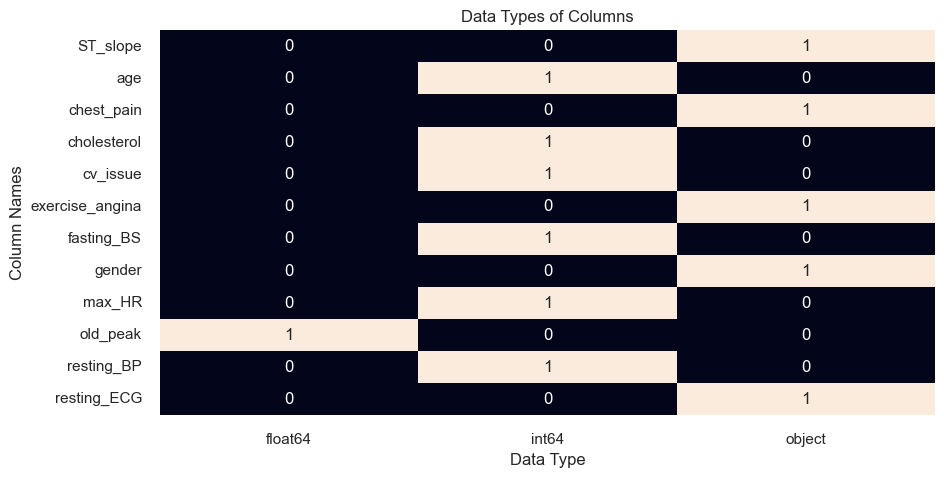

In [7]:
pivot_data_type = data_types_df.pivot_table(index='Column', columns='Data_Type', aggfunc=len, fill_value=0)

# Set up the figure and plot the heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(pivot_data_type,
            annot=True, fmt="d", cbar=False)
plt.title("Data Types of Columns")
plt.xlabel("Data Type")
plt.ylabel("Column Names")
plt.show()

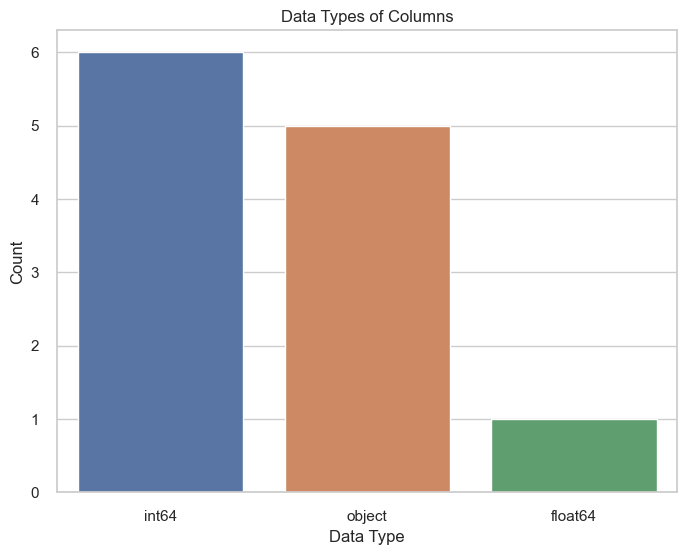

In [8]:

# Count the occurrences of each data type
data_type_counts = data_types_df['Data_Type'].value_counts()

# Set up the figure and plot the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=data_type_counts.index, y=data_type_counts.values)
plt.title("Data Types of Columns")
plt.xlabel("Data Type")
plt.ylabel("Count")
plt.show()

##### Describe Numeric Data

In [9]:
# Overview of the values each column contains (Numeric columns)
df.describe()

age  resting_BP  cholesterol  fasting_BS      max_HR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

         old_peak    cv_issue  
count  918.000000  918.000000  
mean     0.887364    0.553377  
std      1.066570    0.497414  
min     -2.600000    0.000000  
25%      0.000000    0.000000  
50%      0.600000    1.000000  
75%      1.500000    1.000000  
max      6.200000    1.000000

##### Describe Non-Numeric Data

In [10]:
# Overview of the values each column contains (Non-Numeric columns)
df.describe(include=object)

gender chest_pain resting_ECG exercise_angina ST_slope
count     918        918         918             918      918
unique      2          4           3               2        3
top         M        ASY      Normal               N     Flat
freq      725        496         552             547      460

#### Data Quality Assessment

##### Check for Null/Missing Value

I have observed that the dataset does not contain any null values, therefore I will not need to undertake any data cleaning for this problem.

In [11]:
null_counts = df.isna().sum()
null_counts

age                0
gender             0
chest_pain         0
resting_BP         0
cholesterol        0
fasting_BS         0
resting_ECG        0
max_HR             0
exercise_angina    0
old_peak           0
ST_slope           0
cv_issue           0
dtype: int64

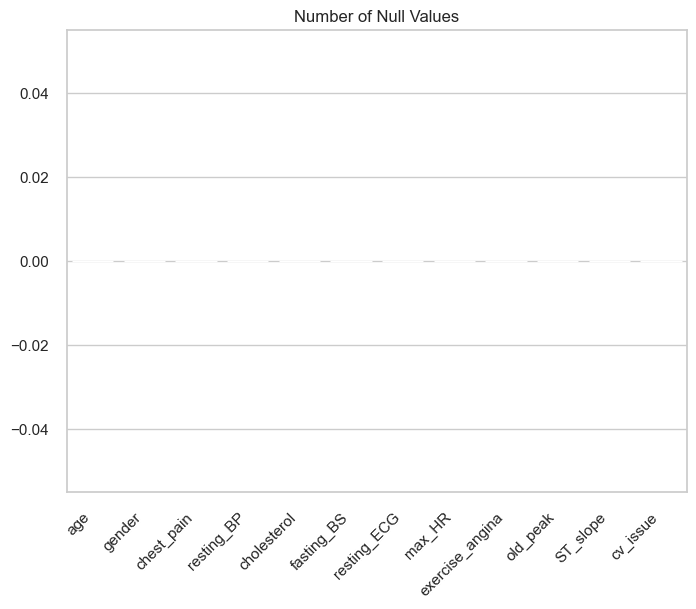

In [12]:

plt.figure(figsize=(8, 6))
sns.barplot(x=null_counts.index, y=null_counts.values)
plt.title('Number of Null Values')
plt.xticks(rotation=45, ha='right')

plt.show()

##### Check for Duplicates

I am not not going to assume that there will/will not have duplicate row as there is no unique_id/unique representable value like name, birth_date_ and other.

- I will retain all rows of data, and duplicates will only be removed if there are from data entry errors or if the same records have been entered multiple times.

- Additionally, no duplicates are found, and even if they are found, I will refrain from removing them, as they might represent meaningful variations in the data or hold valuable information for analysis.


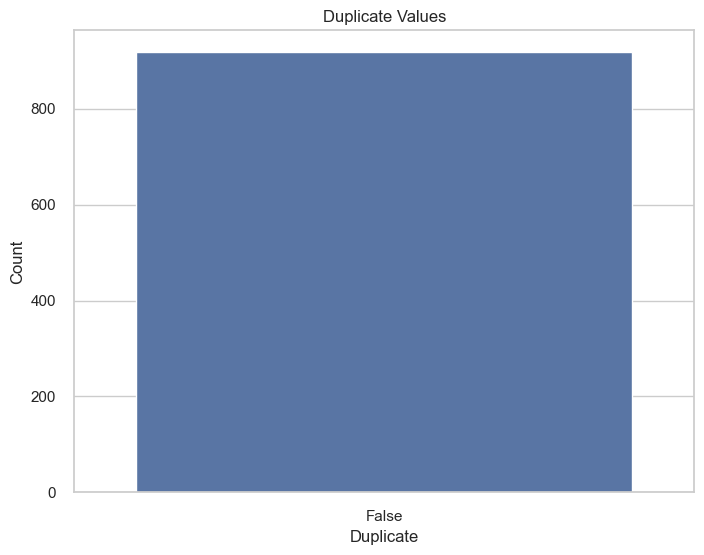

In [13]:
duplicate_counts = df.duplicated().value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=duplicate_counts.index, y=duplicate_counts.values)
plt.title('Duplicate Values')
plt.xlabel('Duplicate')
plt.ylabel('Count')

# Display the chart
plt.show()

##### Check for Outlier

- I have identified the potential presence of outliers in the dataset, as indicated by both boxplots and histograms.

- I am thinking of getting rid of these outliers. It is important to note that outliers have the ability to reduce the accuracy of model predictions. 

- Addressing outliers can enhance the data's integrity, leading to a more robust and accurate analysis based on valid observations.

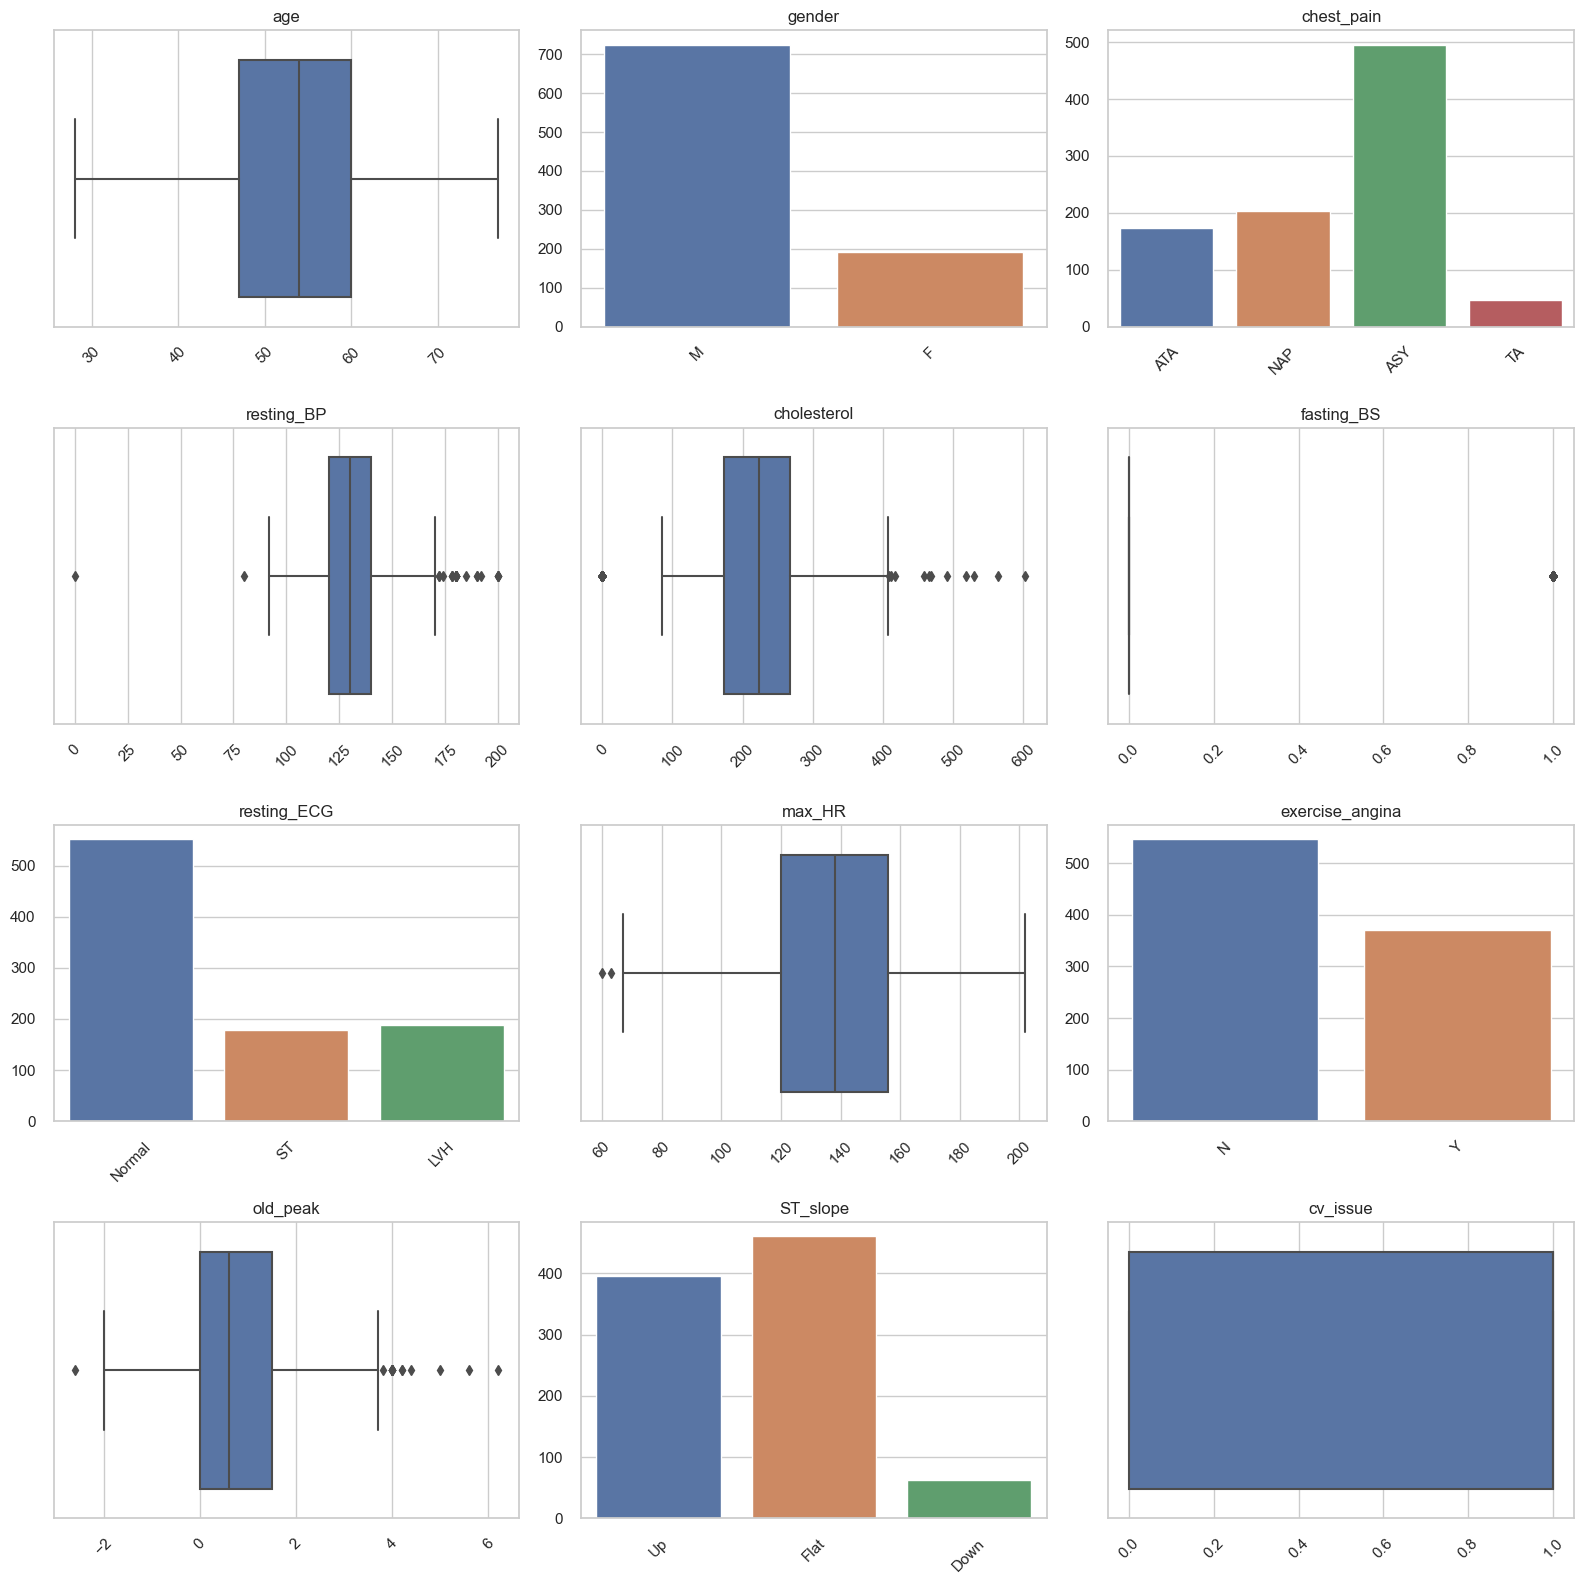

In [14]:
# Define the number of rows and columns for the grid
num_rows = 4
num_cols = 3

# Create a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 16))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over each column and create a distribution plot
for i, column in enumerate(df.columns):
    ax = axes[i]
    if df[column].dtype == 'object':
        sns.countplot(data=df, x=column, ax=ax)
        
    else:
        sns.boxplot(x=df[column], ax=ax)
    ax.set_title(column)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=45)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the chart
plt.show()

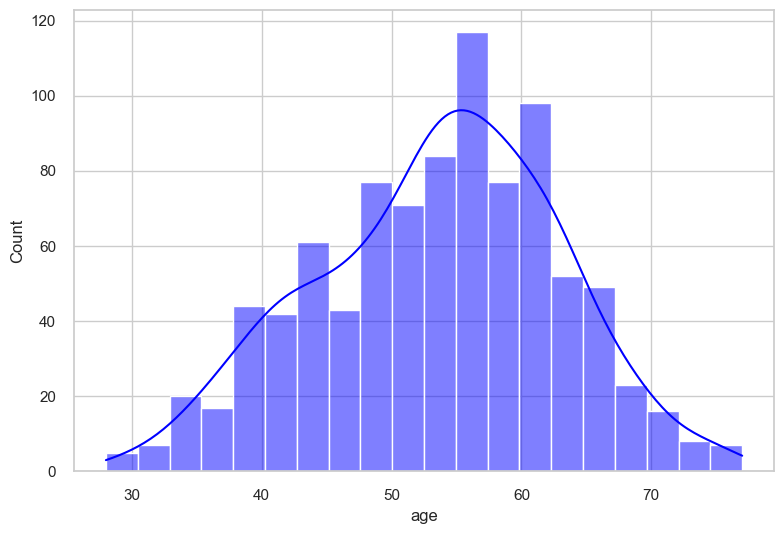

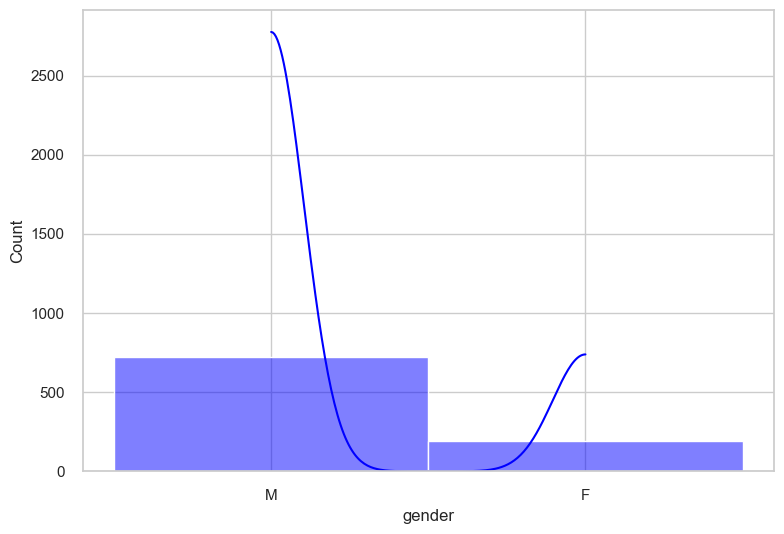

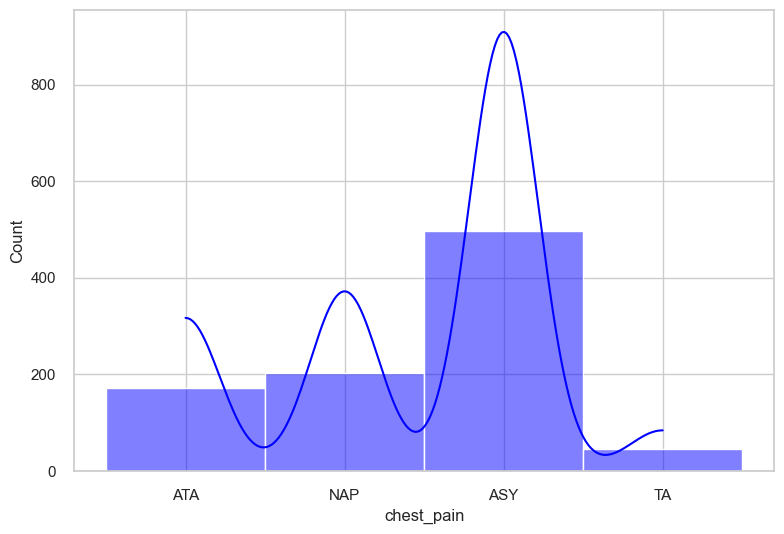

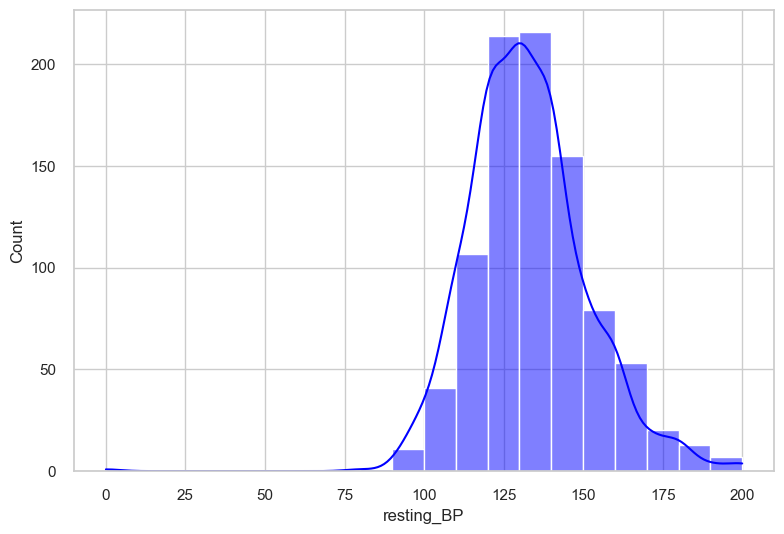

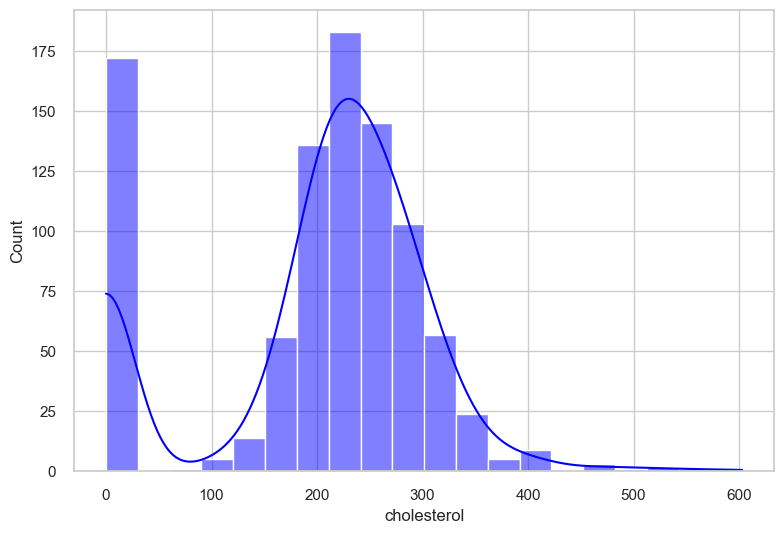

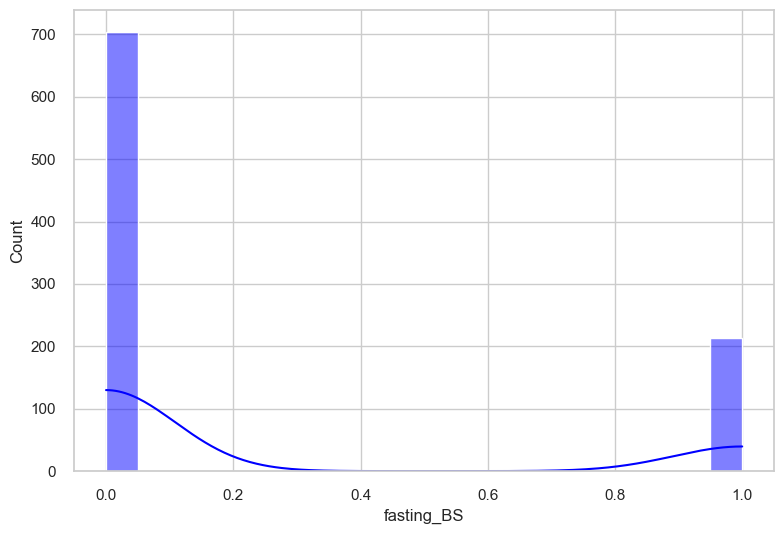

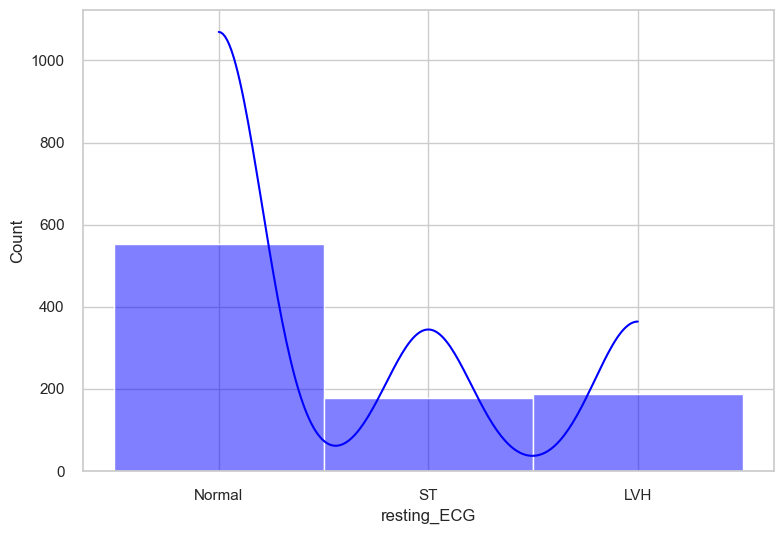

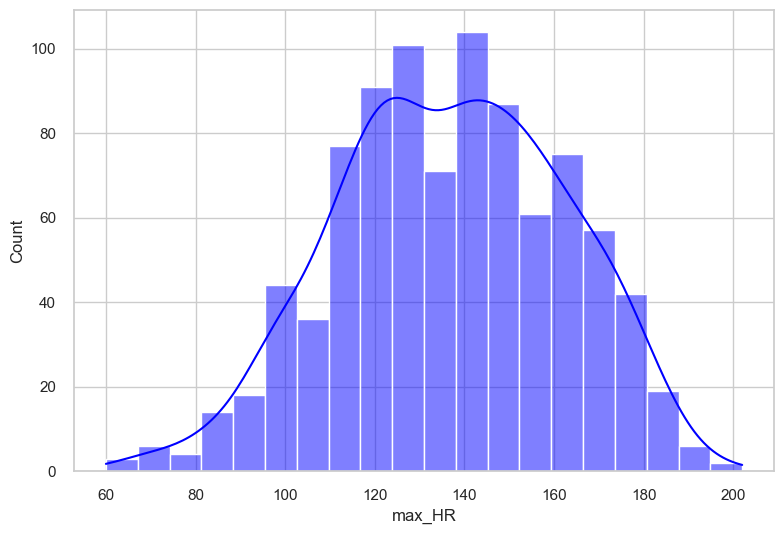

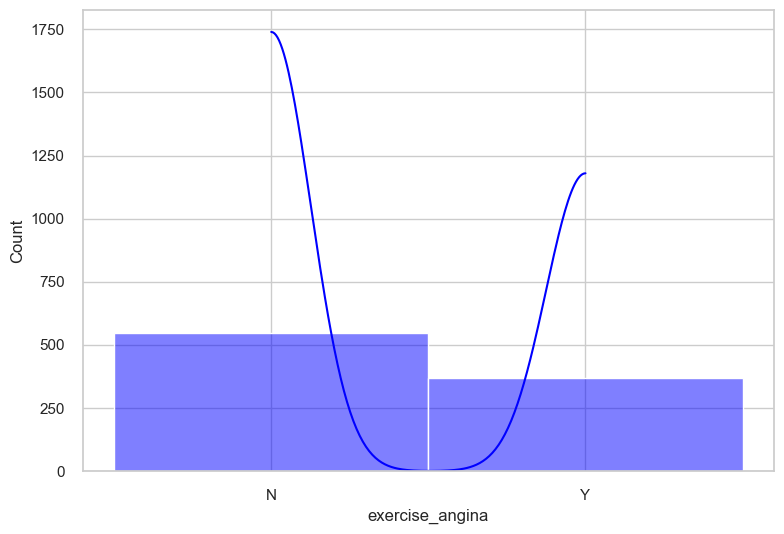

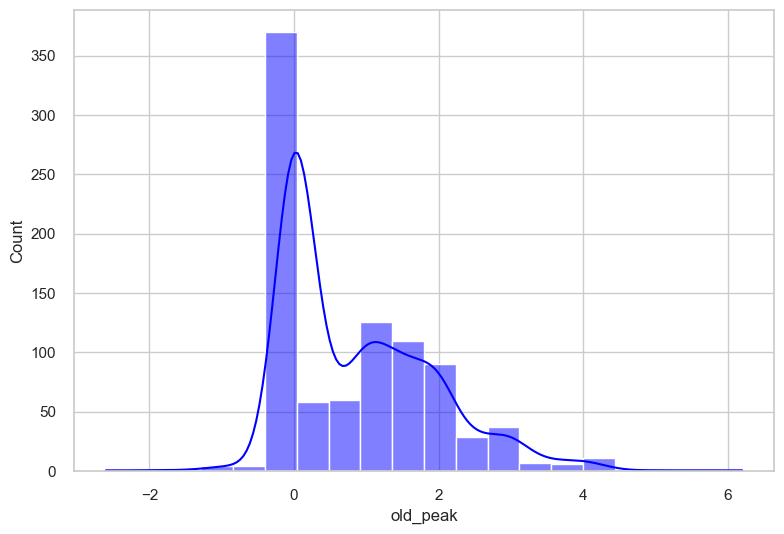

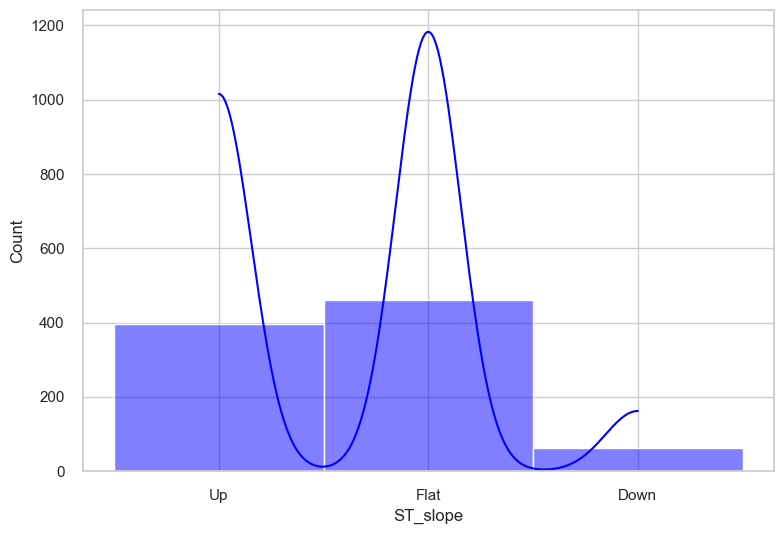

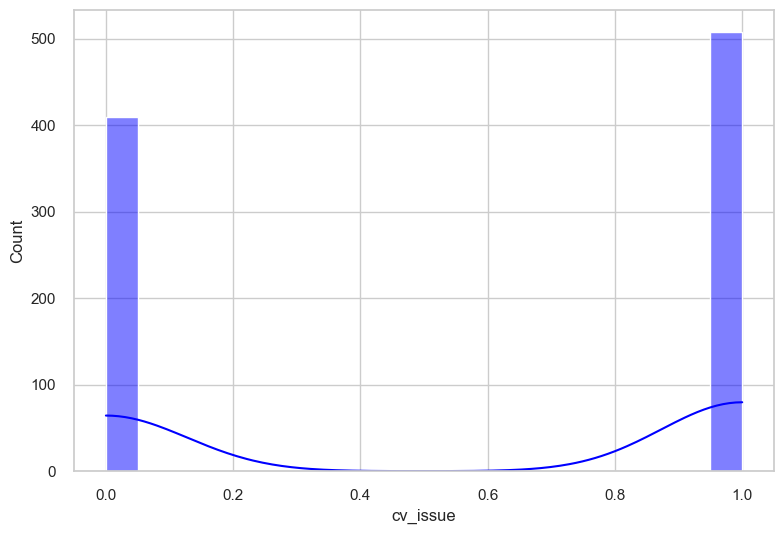

In [15]:
# Iterate over each column and create a distribution plot
for i, column in enumerate(df.columns):
    
    sns.histplot(data=df, x=column, bins=20, kde=True, color='blue')

    plt.tight_layout()

    # Display the chart
    plt.show()

##### Evaluate Balance of Data / Target Variable Data Distribution

In the "cv_issue" column, about 55.3% of the values are 1 and 44.7% are 0. This distribution shows that the classes are not significantly imbalanced. Additionally, with it can result in high bias/variance, which can cause model to be underfitted/overfitted. 

With undersampling it can cause loss of information from the majority class, while over-sampling can potentially introduce noise from duplicated samples.

Sometime balancing classes through sampling techniques might introduce bias or impact the generalization ability of the model. Therefore, I will not conduct any sampling technique as the distribution of "cv_issue" is in my acceptable range.

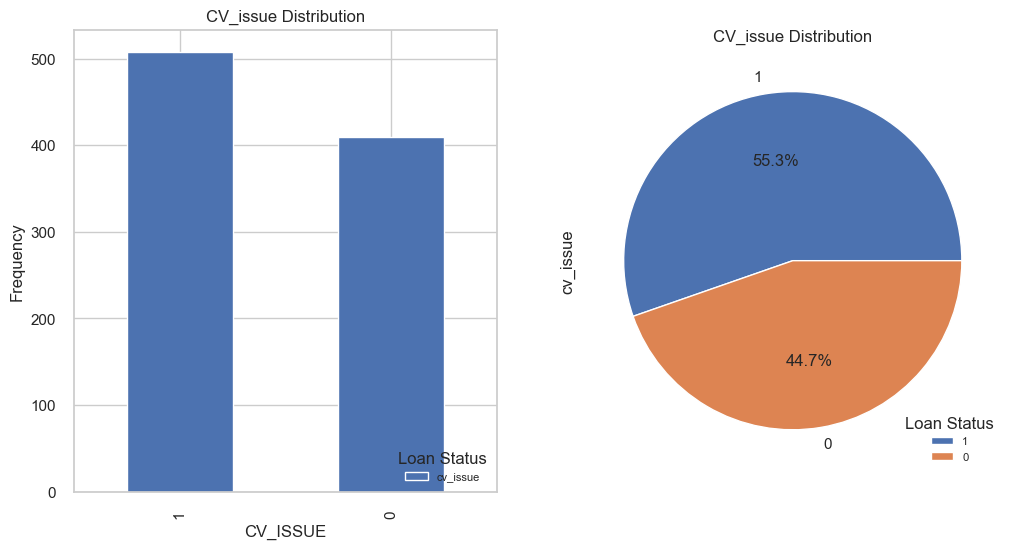

In [16]:
# Create a new figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Count the number of occurrences of each value in the 'cv_issue' column
target_var = df["cv_issue"].value_counts()

# Plot a bar chart
target_var.plot.bar(ax=axs[0], title="CV_issue Distribution")

# Plot a pie chart
target_var.plot.pie(ax=axs[1], title="CV_issue Distribution", autopct='%1.1f%%')

# Add axis labels
axs[0].set_xlabel("CV_ISSUE")
axs[0].set_ylabel("Frequency")

# Add legends
axs[0].legend(loc='lower right', fontsize=8, facecolor='white', edgecolor='black', title='Loan Status')
axs[1].legend(loc='lower right', fontsize=8, facecolor='white', edgecolor='black', title='Loan Status')

# Show the chart
plt.show()

#### Visualisation

##### Correlation Matrix

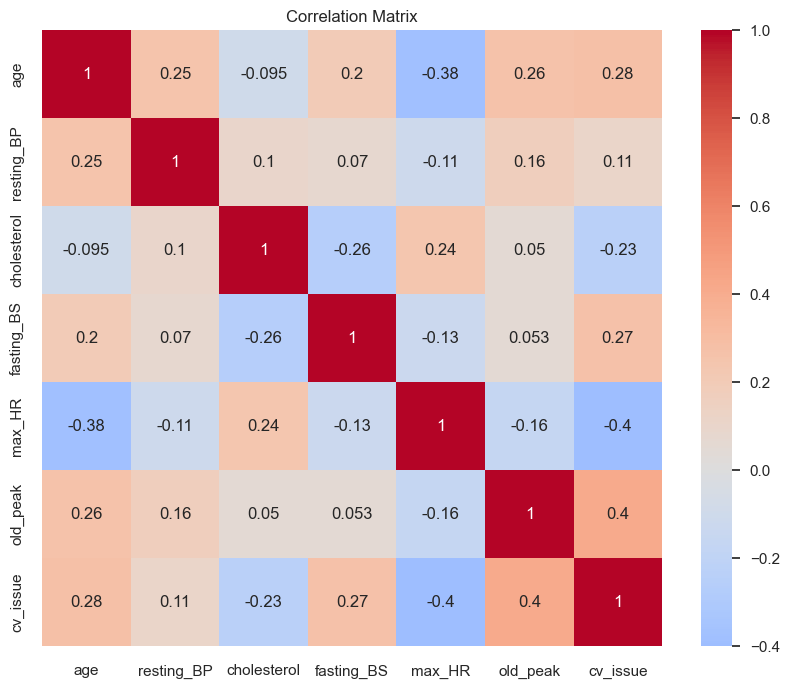

In [17]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

##### Violin Plot

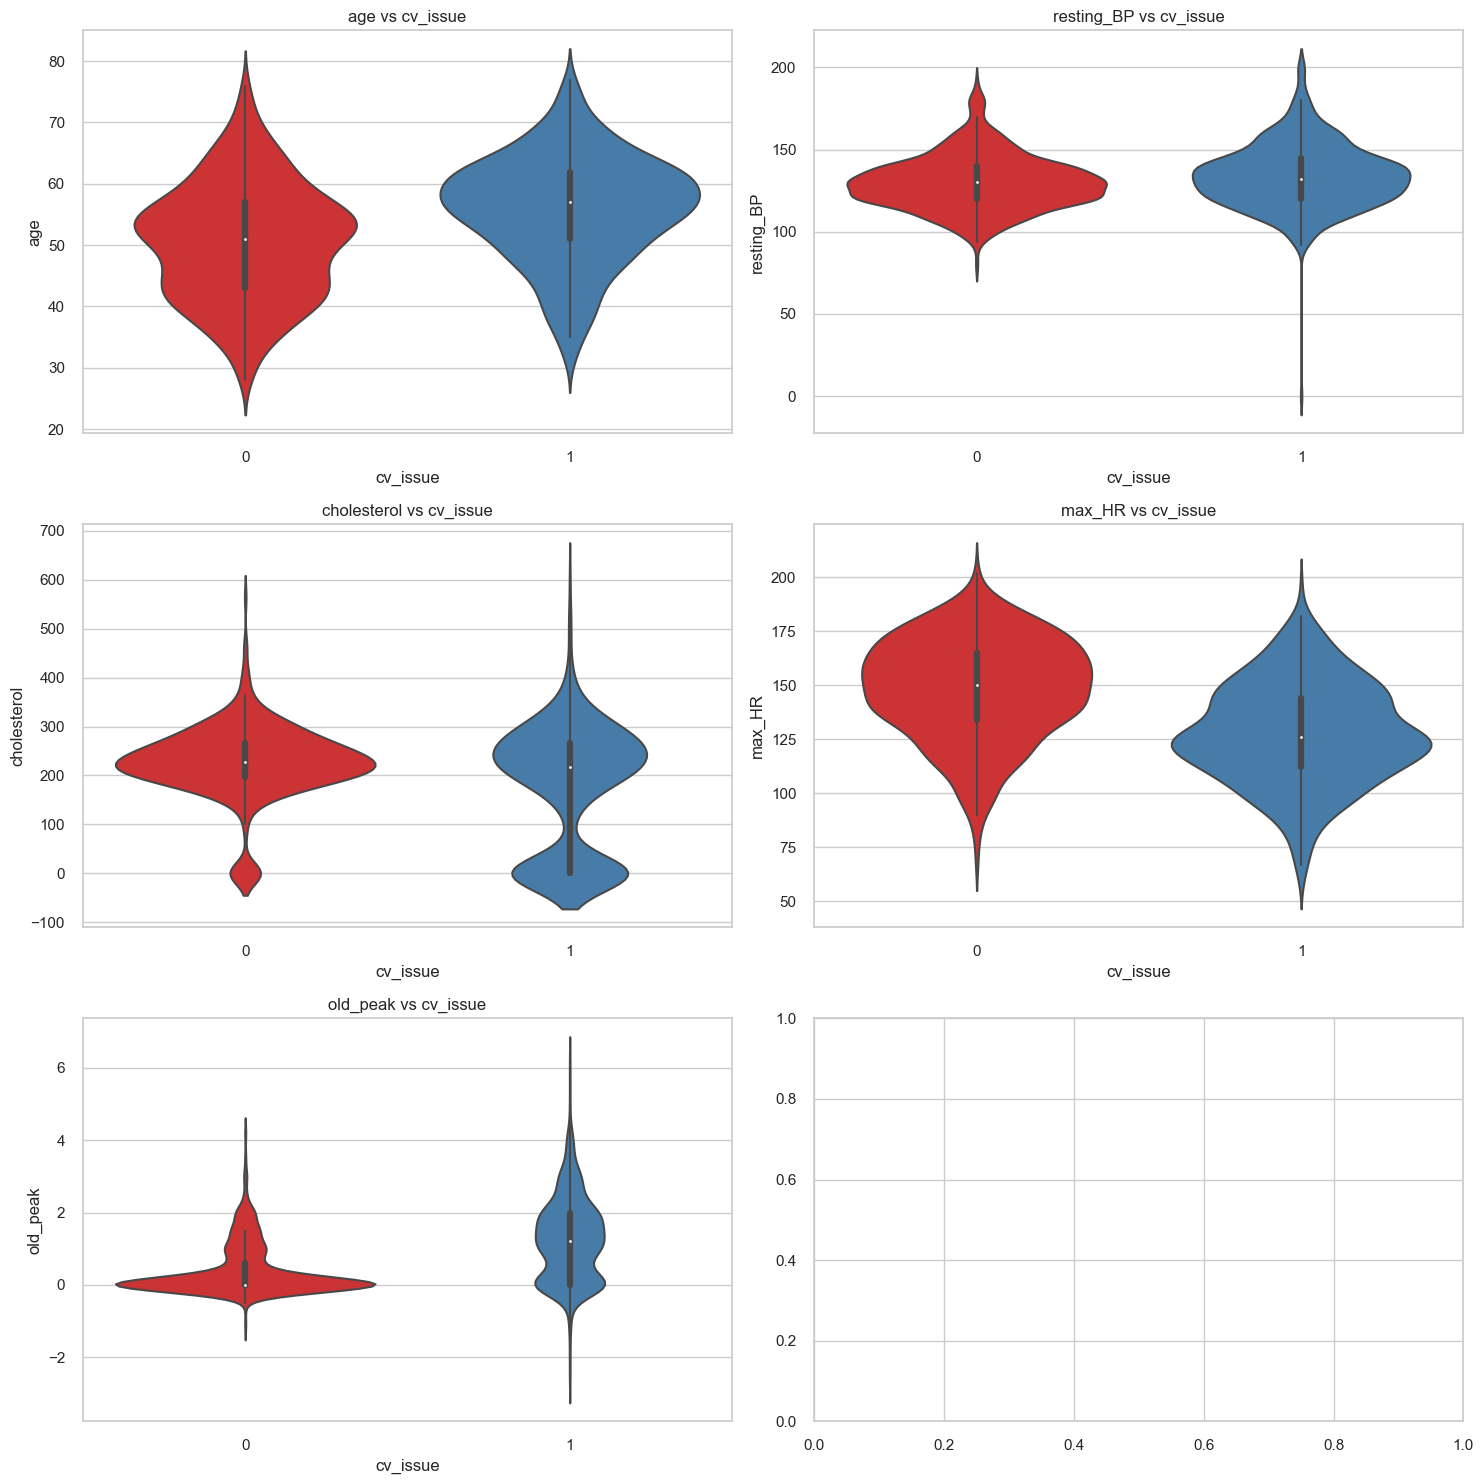

In [18]:
# Create a figure and subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5)

# Numerical features to plot against cv_issue
numerical_features = ['age', 'resting_BP', 'cholesterol', 'max_HR', 'old_peak']

# Loop through the numerical features and create violin plots
for i, feature in enumerate(numerical_features):
    row = i // 2
    col = i % 2
    sns.violinplot(data=df, x='cv_issue', y=feature, ax=axes[row, col], palette='Set1')
    axes[row, col].set_title(f'{feature} vs cv_issue')
    axes[row, col].set_xlabel('cv_issue')
    axes[row, col].set_ylabel(feature)

plt.tight_layout()
plt.show()

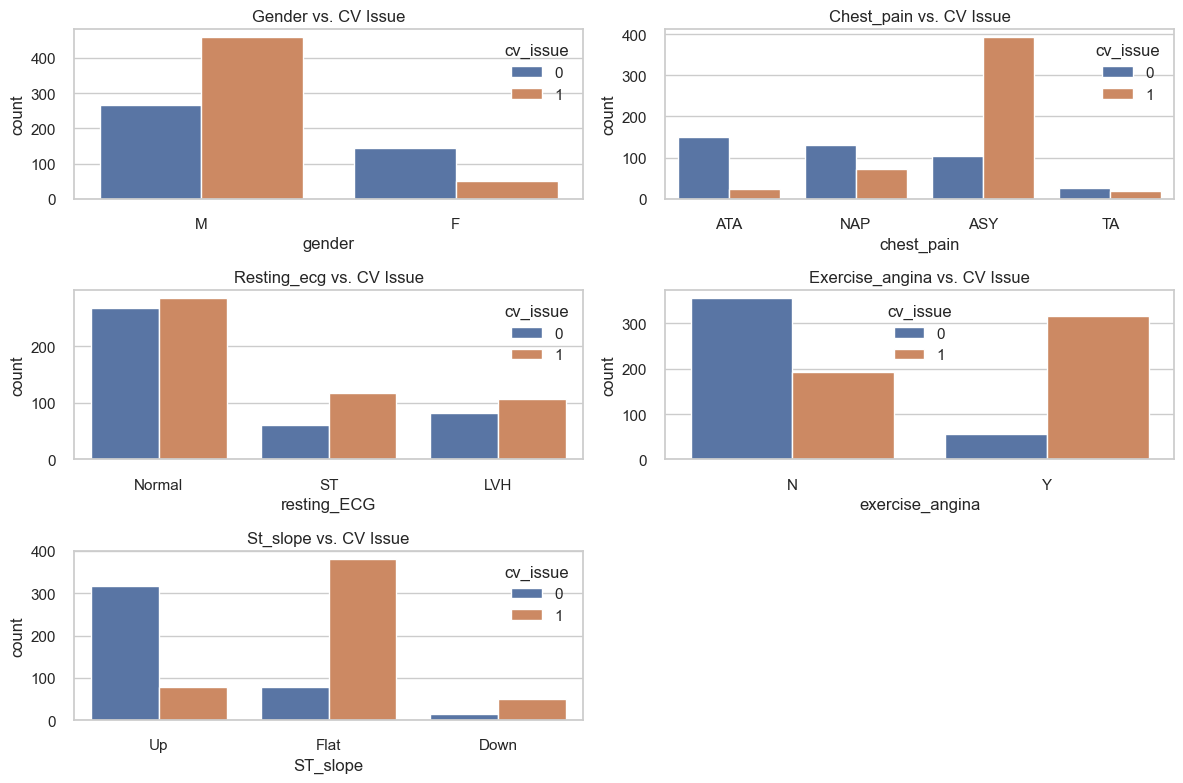

In [19]:
categorical_columns = df.select_dtypes(include=['object']).columns


# Create subplots for categorical variables
num_subplots = len(categorical_columns)
num_cols = 2
num_rows = (num_subplots + 1) // num_cols
plt.figure(figsize=(12, 8))

for i, cat_col in enumerate(categorical_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.countplot(x=cat_col, hue='cv_issue', data=df)
    plt.title(f"{cat_col.capitalize()} vs. CV Issue")

plt.tight_layout()
plt.show()

##### Box-Plot

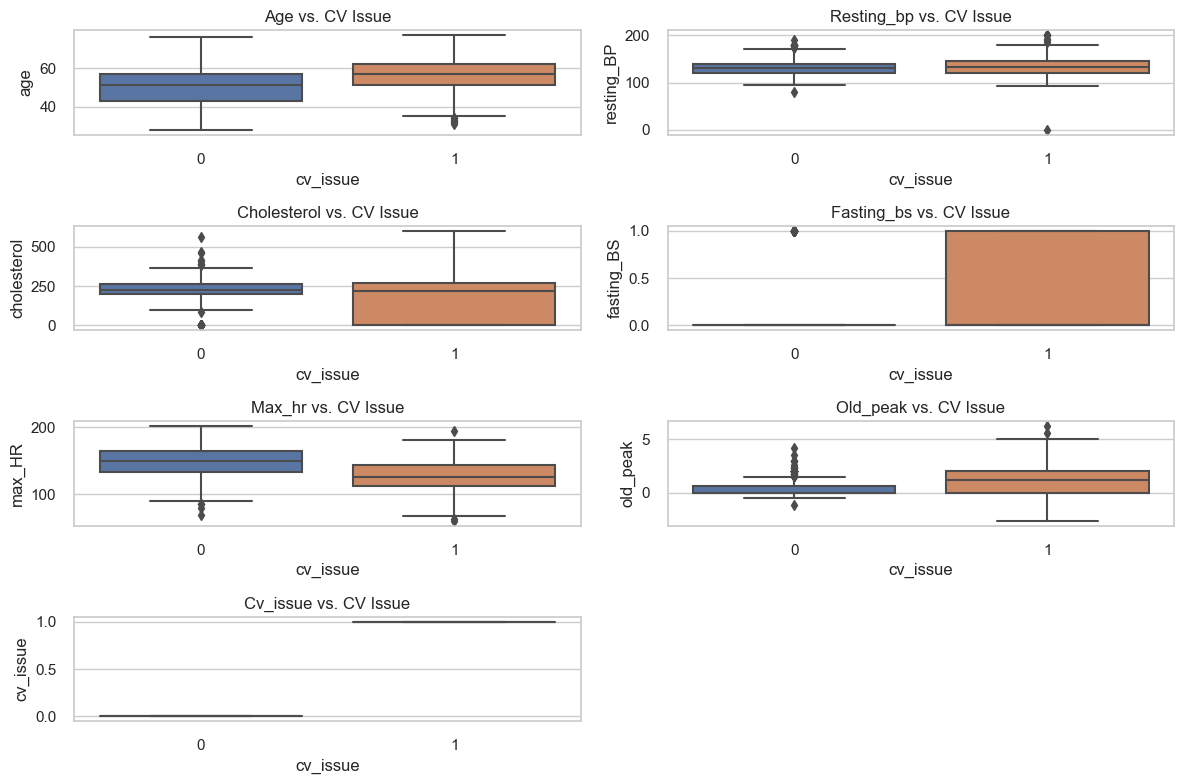

In [20]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

# List of numeric (y) variables for subplots
numeric_variables = list(numeric_columns)

# Create subplots
num_subplots = len(numeric_variables)
num_cols = 2
num_rows = (num_subplots + 1) // num_cols
plt.figure(figsize=(12, 8))

for i, y_var in enumerate(numeric_variables, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(x='cv_issue', y=y_var, data=df)
    plt.title(f"{y_var.capitalize()} vs. CV Issue")

plt.tight_layout()
plt.show()

##### Scatter Plot

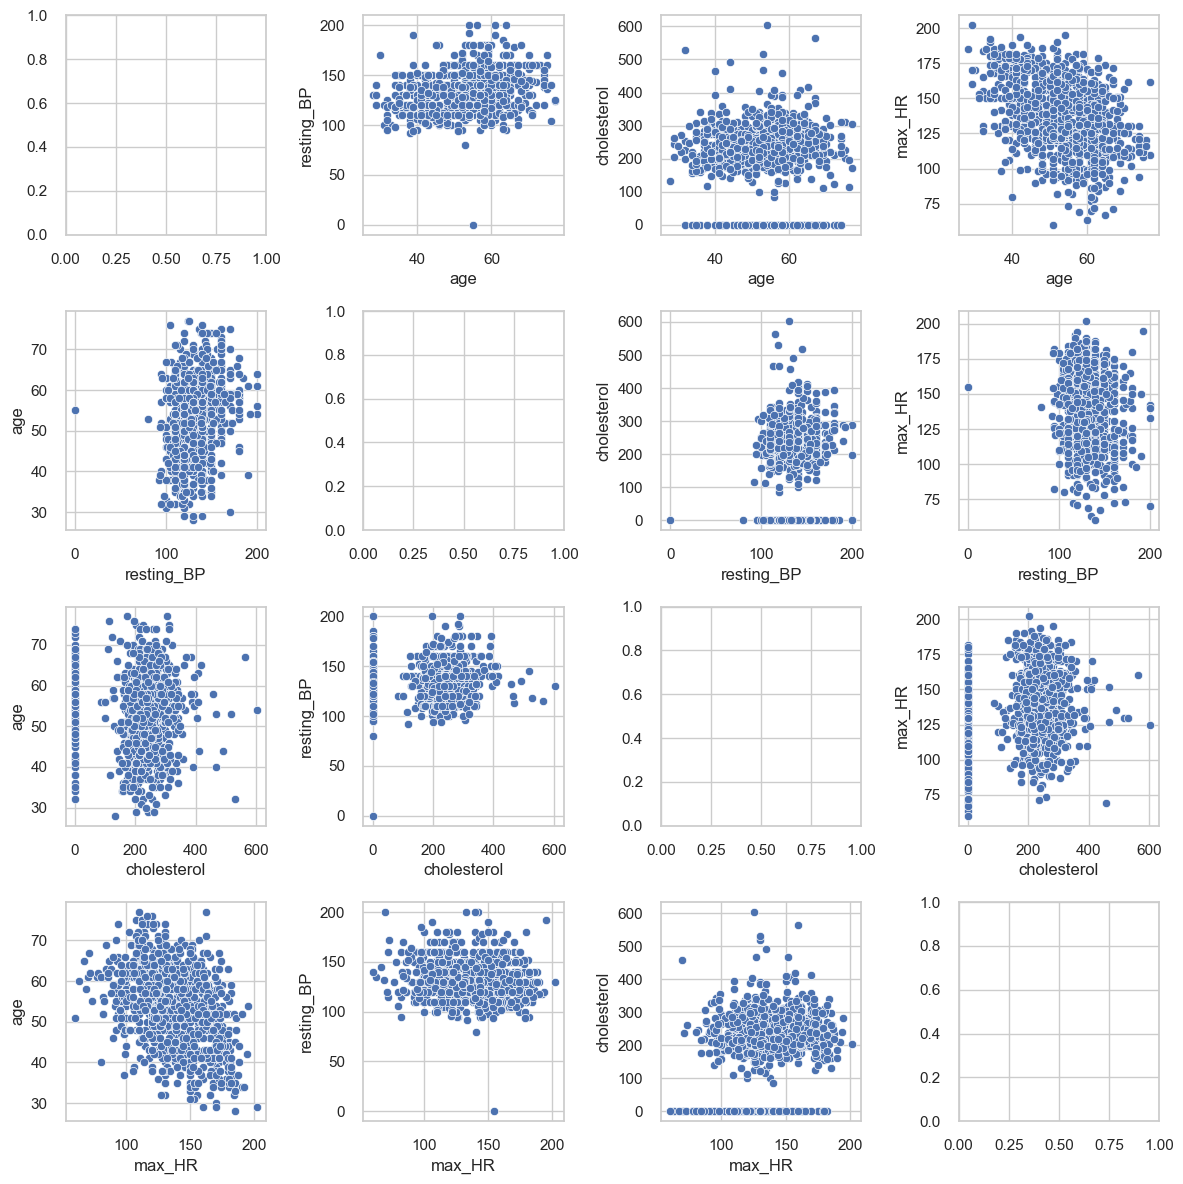

In [21]:
# List of features
features = ['age', 'resting_BP', 'cholesterol', 'max_HR']

# Create a grid of subplots for the pair plots
num_features = len(features)
fig, axes = plt.subplots(num_features, num_features, figsize=(12, 12))

# Iterate through combinations of features and plot scatter plots
for i, feature1 in enumerate(features):
    for j, feature2 in enumerate(features):
        if i != j:
            sns.scatterplot(x=feature1, y=feature2, data=df, ax=axes[i, j])
            axes[i, j].set_xlabel(feature1)
            axes[i, j].set_ylabel(feature2)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

## Modelling

### Best Setup

1. **Missing Value**
    No missing/null value found => Leave as default, I will not configure it.
    ```Bash
    # Default
    imputation_type='simple' # => no imputation if there is no missing
    ```




2. **Identify Features Data Types + One-Hot Encoding + Ordinal Encoding** 

    Make sure all features are identified correctly.

    - **Ordinal_Features**: 

    As I found 2 columns (gender & exercise_angina) that are in binary, I decided to make it a ordinal data, as there are two class only when encode if gender F is encoded as 0 mean that M is encoded as 1, so no point having 1 hot encoding and make a extra column introducing 1 more feature. Additionally, Pycaret are able to identify that  it should not split binary data and create another extra columns. I annotate it for my own visualisation only.

    - **Categorical_Features**: All other categorical data will be one-hot encoded. => Leave as default

    - **Numeric_Features**: Value that are continuous.

    **Justification on Age Column**: Make it Numeric or Categorical?
    
    - One-Hot Encoding the "age" column seems to improve some of the model. However, it was found that applying one-hot encoding on "age" is generally not a recommended approach. 

    - Categorical variables are typically used for qualitative attributes with a limited number of unique values, such as "gender," "color," or "region." Age, on the other hand, is a continuous variable that represents a quantitative measure.

    - Additionally, with age encoded with One-Hot Encoding, it introduces too much features which could lead to problems such as: 

    - Increased in Computational Power and Complexity
    - Overfitting
    - Diminished Interpretability

    Result if I set "age" as categorical
    ```Bash
    # Set
    max_encoding_ohe = 100 # Result => 0.8870
    
    ```
    ![image.png](attachment:image.png)


3. **Target Imbalance** (Not Performing)
    
    - As justified in EDA on evaluate the balance of target variable.

    - In the "cv_issue" column, about 55.3% of the values are 1 and 44.7% are 0. This distribution shows that the classes are not significantly imbalanced. Additionally, with it can result in high bias/variance, which can cause model to be underfitted/overfitted.


    
4. **Remove Outliers**

    - I have identified the potential presence of outliers in the dataset, as indicated by both boxplots and histograms.

    - I am thinking of getting rid of these outliers. It is important to note that outliers have the ability to reduce the accuracy of model predictions. 

    ```Bash
    remove_outliers = True
    outliers_method = 'iforest'
    outliers_theshold = 0.05
    ```
    


5. **Normalization**

    Normalization ensures that all features have similar scales, aiding algorithms like gradient descent to converge faster and more reliably. It prevents overflow issues that can reult in having a few large feature values.


6. **Train Test Split**

    Split data into
    - Training Set = 80 %
    - Testing Set = 20%
    
    ```Bash
    train_size=0.8,
    ```

7. **Feature Selection**:
    
    Based on the feature importance plot, I feel it is OK for me to skip the process of removing a few features to apply. This is due to the possibility of losing important data. Furthermore, the plot shows that all of the qualities are somewhat important, therefore there is no need to exclude those that do not appear to be extremely important.

    ![image-2.png](attachment:image-2.png)



8. **Bin Numeric Features (AGE)**

    Tried => Performance not as good.


9. **Polynomial Features**
    With the configuration below addded, the accuracy do improve however learning curve decreases at the end by a little for the testing set => Not using.
    ```Bash
    polynomial_features=True,
    polynomial_degree = 2
    ```
    

### Final Setup

In [22]:
clf = setup(
            data=df, 
            target=cfg.features.target_features,
            session_id=1,
            categorical_features = cfg.features.categorical_features, 
            numeric_features = cfg.features.numeric_features,
            ignore_features =  cfg.features.drop_features,
            ordinal_features = cfg.features.ordinal_features,
            train_size=cfg.setup.train_size,

            # Remove Local Memory to integrate
            memory=cfg.setup.memory,

            # This portion will be adjust frequently & used here only 
            # => Not going to use hydra to setup

            # Normalize Data
            normalize=True,
            # Default removal of outliers
            remove_outliers = True,
            outliers_threshold = 0.05,
            outliers_method = 'iforest',
            
            # MLFLOW Experiment
            log_experiment = True,
            experiment_name='cv_issues_exp'
           )

2023/08/21 01:46:16 INFO mlflow.tracking.fluent: Experiment with name 'cv_issues_exp' does not exist. Creating a new experiment.


In [23]:
# Pre-Processed Data
transformed_df = clf.get_config('dataset_transformed')

# Save it to Processed Folder
data_processed_file = parent_dir  + cfg.dataset.processed_data

transformed_df.to_csv(file_path, index=False)


transformed_df

age    gender  chest_pain_ASY  chest_pain_TA  chest_pain_ATA  \
209  0.071116  0.485608        0.902831      -0.188842       -0.505822   
656  0.958236 -2.059272        0.902831      -0.188842       -0.505822   
451  1.180016  0.485608        0.902831      -0.188842       -0.505822   
545 -0.594224  0.485608        0.902831      -0.188842       -0.505822   
685  0.847346  0.485608        0.902831      -0.188842       -0.505822   
..        ...       ...             ...            ...             ...   
684 -0.705114  0.485608       -1.107627      -0.188842       -0.505822   
673  0.625566 -2.059272        0.902831      -0.188842       -0.505822   
349 -1.924905  0.485608        0.902831      -0.188842       -0.505822   
848 -0.150664  0.485608        0.902831      -0.188842       -0.505822   
778  0.514676  0.485608        0.902831      -0.188842       -0.505822   

     chest_pain_NAP  resting_BP  cholesterol  fasting_BS  resting_ECG_Normal  \
209       -0.516984   -0.381476     0.163887   -0.512524            0.787991   
656       -0.516984   -0.436731     0.099356   -0.512524            0.787991   
451       -0.516984    0.668376    -1.827362   -0.512524           -1.269050   
545       -0.516984    0.005311     0.680137   -0.512524           -1.269050   
685       -0.516984   -0.657753     0.569512   -0.512524            0.787991   
..              ...         ...          ...         ...                 ...   
684        1.934295   -1.320817     0.412793   -0.512524            0.787991   
673       -0.516984    2.326036     0.468106   -0.512524            0.787991   
349       -0.516984   -1.210306    -1.827362    1.951127            0.787991   
848       -0.516984   -0.215710     0.523418   -0.512524            0.787991   
778       -0.516984   -0.215710     0.560293   -0.512524           -1.269050   

     resting_ECG_ST  resting_ECG_LVH    max_HR  exercise_angina  old_peak  \
209       -0.494614        -0.478829  0.121648        -0.819428 -0.835694   
656       -0.494614        -0.478829  1.025329        -0.819428 -0.835694   
451        2.021779        -0.478829 -0.585580         1.220363  0.139329   
545        2.021779        -0.478829  0.082358        -0.819428 -0.640689   
685       -0.494614        -0.478829  0.121648         1.220363  2.674389   
..              ...              ...       ...              ...       ...   
684       -0.494614        -0.478829  0.593134        -0.819428 -0.835694   
673       -0.494614        -0.478829  0.239520         1.220363 -0.835694   
349       -0.494614        -0.478829 -0.467709         1.220363  0.139329   
848       -0.494614        -0.478829  0.946748         1.220363 -0.835694   
778       -0.494614         2.088430 -0.271256         1.220363  2.089375   

     ST_slope_Flat  ST_slope_Up  ST_slope_Down  cv_issue  
209       0.964753    -0.884652      -0.212079         1  
656      -1.036535     1.130388      -0.212079         0  
451       0.964753    -0.884652      -0.212079         1  
545      -1.036535     1.130388      -0.212079         0  
685       0.964753    -0.884652      -0.212079         1  
..             ...          ...            ...       ...  
684      -1.036535     1.130388      -0.212079         1  
673       0.964753    -0.884652      -0.212079         1  
349       0.964753    -0.884652      -0.212079         1  
848      -1.036535     1.130388      -0.212079         1  
778       0.964753    -0.884652      -0.212079         1  

[881 rows x 19 columns]

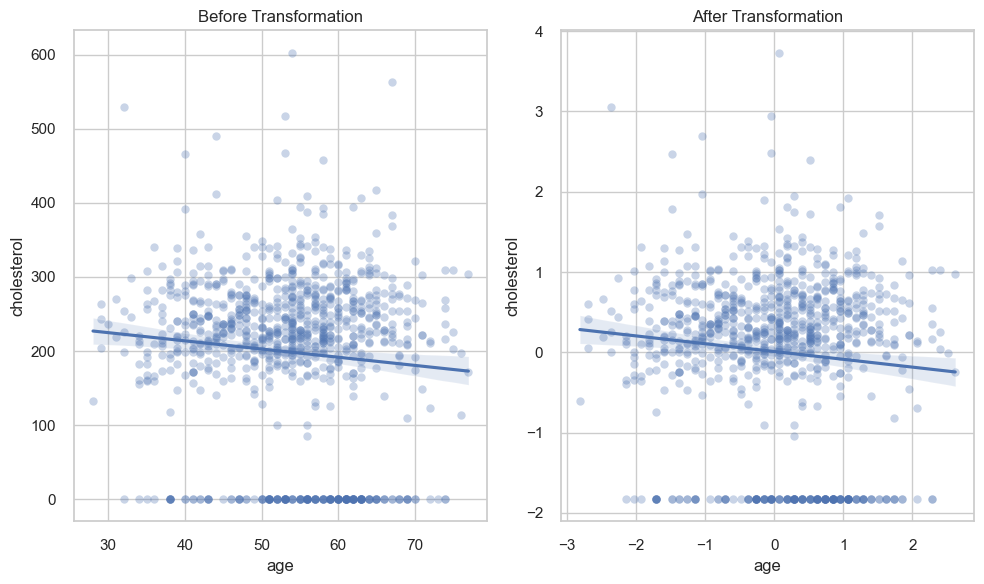

In [24]:
plt.figure(figsize=(10, 6))

# Before transformation
plt.subplot(1, 2, 1)
sns.regplot(x=df['age'], y=df['cholesterol'], scatter_kws={'alpha':0.3})
plt.title('Before Transformation')

# After transformation
plt.subplot(1, 2, 2)
sns.regplot(x=transformed_df['age'], y=transformed_df['cholesterol'], scatter_kws={'alpha':0.3})
plt.title('After Transformation')

plt.tight_layout()
plt.show()

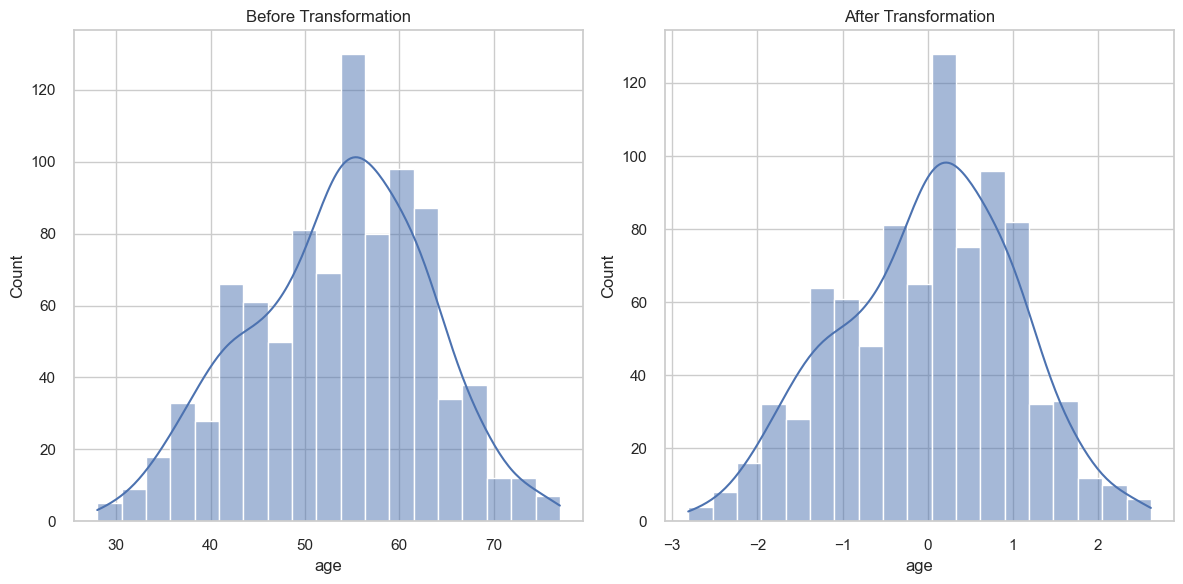

In [25]:
# Before transformation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['age'], kde=True)
plt.title('Before Transformation')

# After transformation
plt.subplot(1, 2, 2)
sns.histplot(transformed_df['age'], kde=True)
plt.title('After Transformation')

plt.tight_layout()
plt.show()

In [26]:
# check available models
models()

Name  \
ID                                          
lr                    Logistic Regression   
knn                K Neighbors Classifier   
nb                            Naive Bayes   
dt               Decision Tree Classifier   
svm                   SVM - Linear Kernel   
rbfsvm                SVM - Radial Kernel   
gpc           Gaussian Process Classifier   
mlp                        MLP Classifier   
ridge                    Ridge Classifier   
rf               Random Forest Classifier   
qda       Quadratic Discriminant Analysis   
ada                  Ada Boost Classifier   
gbc          Gradient Boosting Classifier   
lda          Linear Discriminant Analysis   
et                 Extra Trees Classifier   
lightgbm  Light Gradient Boosting Machine   
catboost              CatBoost Classifier   
dummy                    Dummy Classifier   

                                                  Reference  Turbo  
ID                                                                  
lr        sklearn.linear_model._logistic.LogisticRegression   True  
knn       sklearn.neighbors._classification.KNeighborsCl...   True  
nb                           sklearn.naive_bayes.GaussianNB   True  
dt             sklearn.tree._classes.DecisionTreeClassifier   True  
svm       sklearn.linear_model._stochastic_gradient.SGDC...   True  
rbfsvm                             sklearn.svm._classes.SVC  False  
gpc       sklearn.gaussian_process._gpc.GaussianProcessC...  False  
mlp       sklearn.neural_network._multilayer_perceptron....  False  
ridge           sklearn.linear_model._ridge.RidgeClassifier   True  
rf          sklearn.ensemble._forest.RandomForestClassifier   True  
qda       sklearn.discriminant_analysis.QuadraticDiscrim...   True  
ada       sklearn.ensemble._weight_boosting.AdaBoostClas...   True  
gbc         sklearn.ensemble._gb.GradientBoostingClassifier   True  
lda       sklearn.discriminant_analysis.LinearDiscrimina...   True  
et            sklearn.ensemble._forest.ExtraTreesClassifier   True  
lightgbm                    lightgbm.sklearn.LGBMClassifier   True  
catboost                   catboost.core.CatBoostClassifier   True  
dummy                         sklearn.dummy.DummyClassifier   True

In [27]:
#Print ordinal, numeric and categorical features
print(f'Ordinal features: {clf._fxs["Ordinal"]}')
print(f'Numeric features: {clf._fxs["Numeric"]}')
print(f'Categorical features: {clf._fxs["Categorical"]}')

Ordinal features: {'gender': ['F', 'M'], 'exercise_angina': ['N', 'Y']}
Numeric features: ['age', 'resting_BP', 'cholesterol', 'fasting_BS', 'max_HR', 'old_peak']
Categorical features: ['gender', 'chest_pain', 'resting_ECG', 'exercise_angina', 'ST_slope']


### Model Deicision

**Accuracy**

Accuracy is a can give a quick metric that provides a basic understanding of how well the model is performing overall.


**Recall** (Second to look at)

- In medical scenarios, false negatives can lead to serious health consequences or missed diagnoses, high recall is important.

- In health screening, it's critical to detect true positive cases even if it results in some false positives.

- Example: In a disease outbreak, I would prefer to have high recall to ensure that all actual cases are identified, even if it means some false alarms.

**precision** (Third to look at)

Determines whether a patient requires urgent surgery, a high precision can help to minimize the number of unnecessary surgeries.

### Compare all model Through below

#### Metrics

These are metrics that I look for to decide on best model.

- **Accuracy:** The proportion of correctly classified instances out of all instances
- **Precision:** The proportion of true positives (correctly classified positive instances) out of all positive predictions
- **Recall:** The proportion of true positives out of all actual positive instances
- **F1 score:** The harmonic mean of precision and recall, with equal weight given to both metrics. Like an Average.


#### Visuals

- **Confusion Martrix:** Summarizes the performance of a classification and provides a detailed breakdown of the predicted classes compared to the actual classes.

- **ROC Curve/Sensitiviy vs Specificity:** Graphical representation of a classifier's performance as the discrimination threshold is varied. It shows the trade-off between the true positive rate (sensitivity) and the false positive rate (1 - specificity).

- **Precision-Recall:** Helps find the optimal threshold that aligns with the desired balance between precision and recall, depending on the specific context of problem.

- **Learning-Curve:** Learning curves provide insights into how well your model is learning from the data. Help in detecting whether model is overfitting or underfitting.

In [28]:
best_model = compare_models()

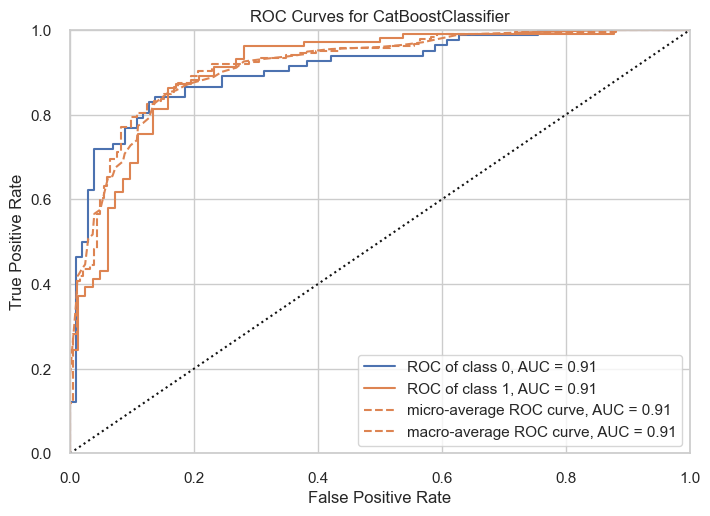

In [29]:
plot_model(best_model, plot = 'auc')

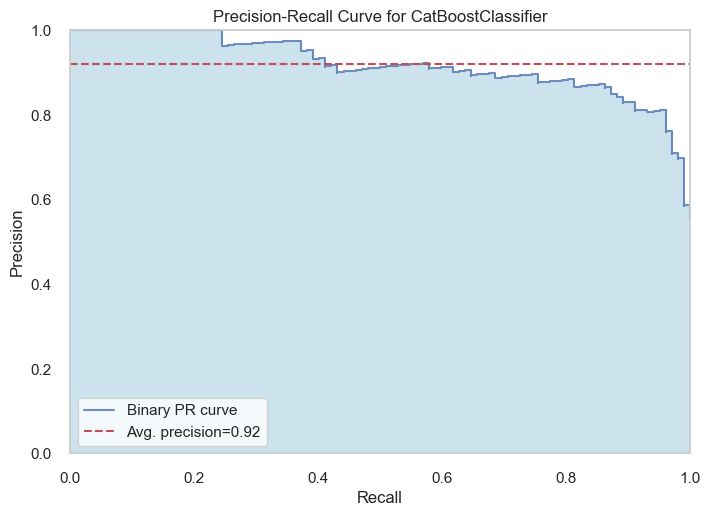

In [30]:
plot_model(best_model, plot = 'pr')

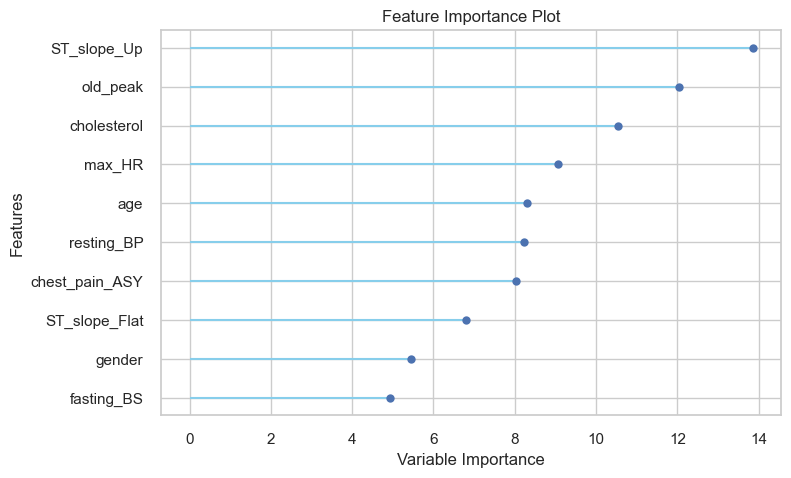

In [31]:
plot_model(best_model, plot='feature')

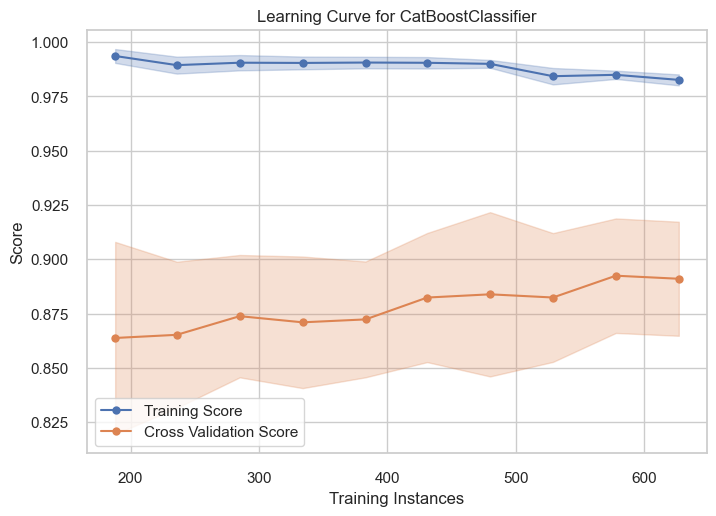

In [32]:
plot_model(best_model, plot='learning')

In [33]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Tune Hyperparameters - Best Model

In [34]:
tuned_model = tune_model(best_model)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [35]:
# check the final params of best model
tuned_model.get_params()

{'border_count': 254, 'verbose': False, 'task_type': 'CPU', 'random_state': 1}

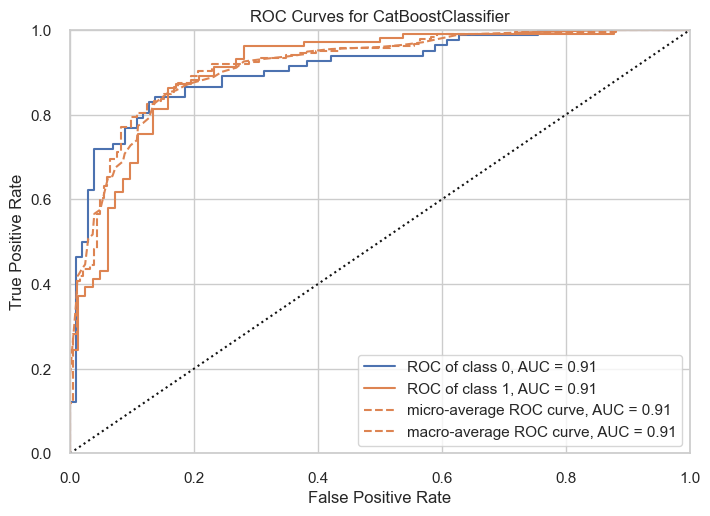

In [36]:
plot_model(tuned_model, plot = 'auc')

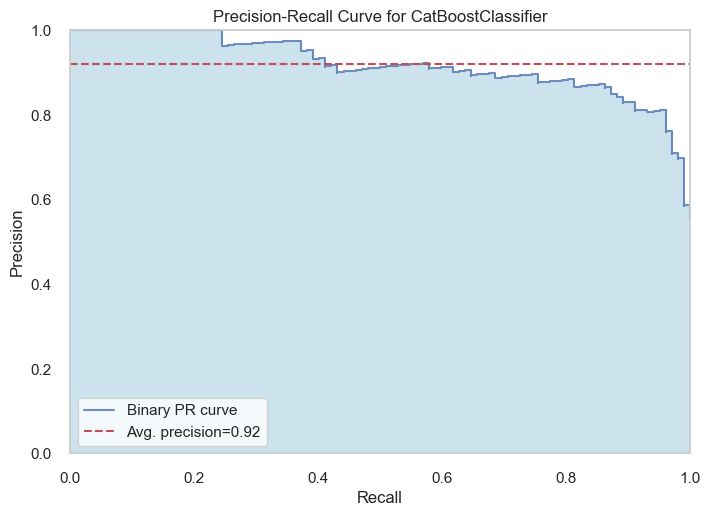

In [37]:
plot_model(tuned_model, plot = 'pr')

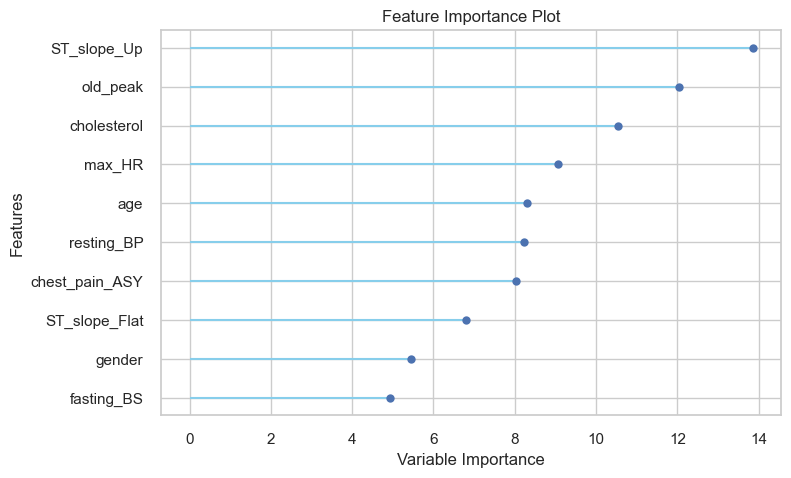

In [38]:
plot_model(tuned_model, plot='feature')

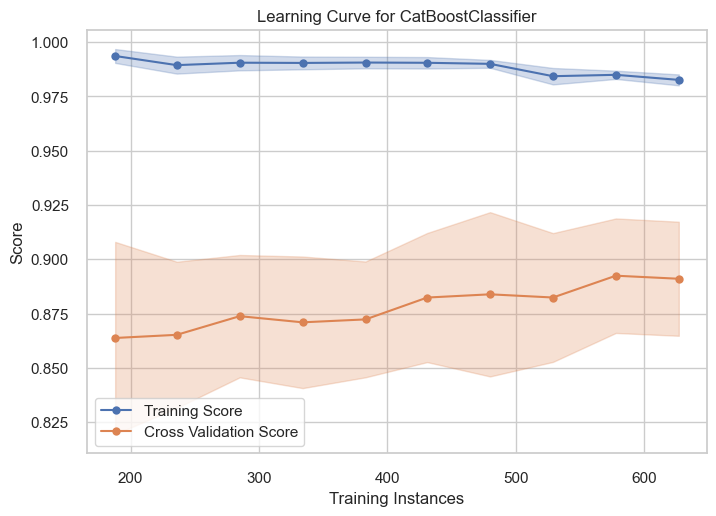

In [39]:
plot_model(tuned_model, plot='learning')

In [40]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Voting Estimator: Blend Top-3 Models - Best Performance (Selected)

All Metrics and visuals shows better performance

Best 3: Catboost Classifier, Random Forest & Gradient Boosting Classifier

In [41]:
# Compare models and select the top 3
top3_models = compare_models(n_select=3)

In [ ]:
tuned_top3 = []

for model in top3_models:
    tuned_model = tune_model(model)
    tuned_top3.append(tuned_model)


### Tune Hyperparameters - Blended Model

### Tune Hyperparameters - Top 3 Blending Model

In [ ]:
blended_model = blend_models(estimator_list=tuned_top3)


In [43]:
# check the final params of best model
blended_model.get_params()

{'estimators': [('CatBoost Classifier',
   <catboost.core.CatBoostClassifier at 0x199c434e520>),
  ('Random Forest Classifier',
   RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                          criterion='gini', max_depth=None, max_features='sqrt',
                          max_leaf_nodes=None, max_samples=None,
                          min_impurity_decrease=0.0, min_samples_leaf=1,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=100, n_jobs=-1, oob_score=False,
                          random_state=1, verbose=0, warm_start=False)),
  ('Gradient Boosting Classifier',
   GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                              learning_rate=0.1, loss='log_loss', max_depth=3,
                              max_features=None, max_leaf_nodes=None,
                              min_impurity_decrease=0.0, min_samples_leaf=1,
            

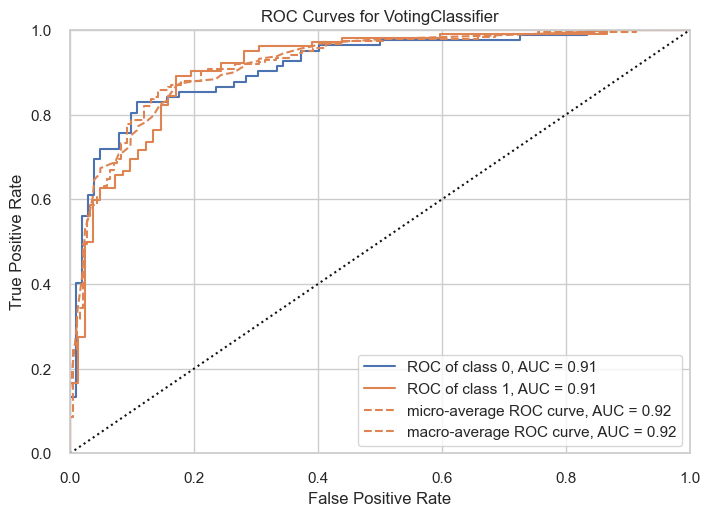

In [44]:
plot_model(blended_model, plot = 'auc')

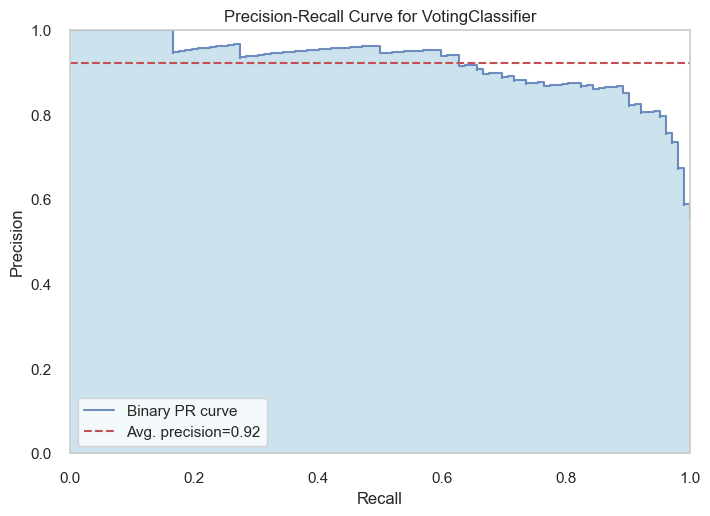

In [45]:
plot_model(blended_model, plot = 'pr')

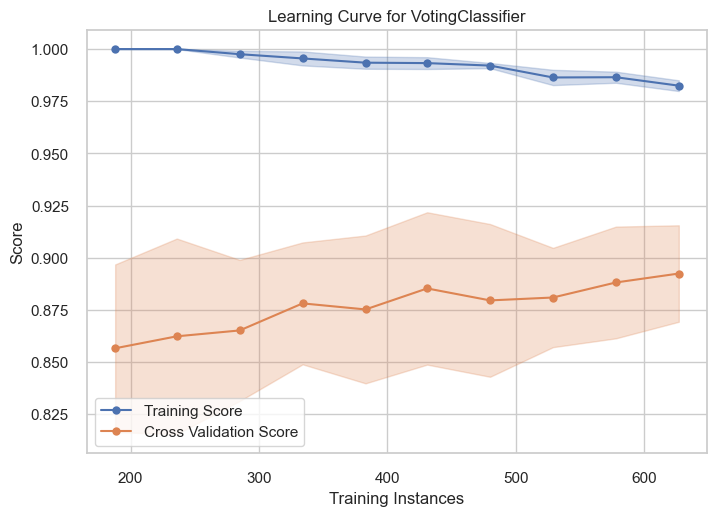

In [46]:
plot_model(blended_model, plot='learning')

In [47]:
# Evaluate the blended model
evaluate_model(blended_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [49]:
# check the final params of best model
blended_model.get_params()

{'estimators': [('CatBoost Classifier',
   <catboost.core.CatBoostClassifier at 0x199c4cfa4f0>),
  ('Random Forest Classifier',
   RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                          criterion='gini', max_depth=None, max_features='sqrt',
                          max_leaf_nodes=None, max_samples=None,
                          min_impurity_decrease=0.0, min_samples_leaf=1,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=100, n_jobs=-1, oob_score=False,
                          random_state=1, verbose=0, warm_start=False)),
  ('Gradient Boosting Classifier',
   GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                              learning_rate=0.1, loss='log_loss', max_depth=3,
                              max_features=None, max_leaf_nodes=None,
                              min_impurity_decrease=0.0, min_samples_leaf=1,
            

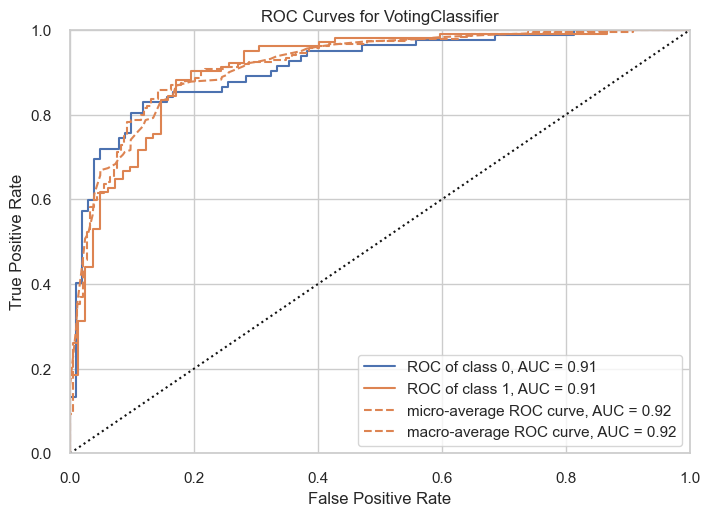

In [50]:
plot_model(blended_model, plot = 'auc')

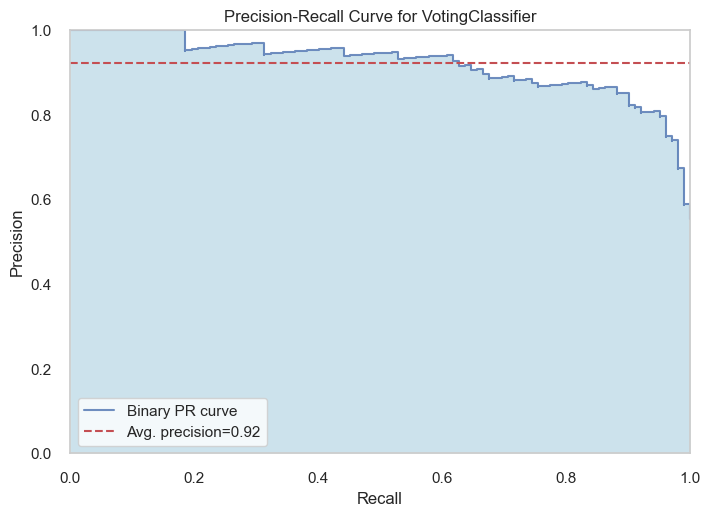

In [51]:
plot_model(blended_model, plot = 'pr')

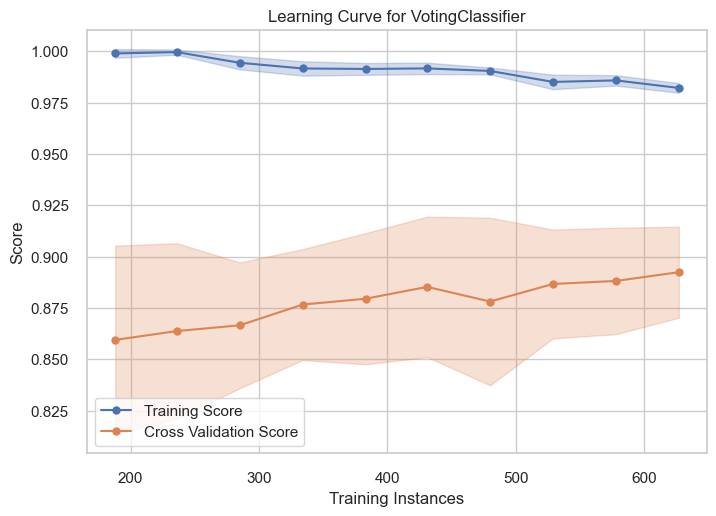

In [54]:
plot_model(blended_model, plot='learning')

In [55]:
evaluate_model(blended_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Evaluate Best Model

Identifying tuned_model as the best model.

In [56]:
# Train model with full data 
# Instead of just training set after building the model.
final_best = finalize_model(blended_model)

In [61]:
# save model to local file system
save_model(blended_model, parent_dir + cfg.file_location.generate_pkl)


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['age', 'resting_BP', 'cholesterol',
                                              'fasting_BS', 'max_HR',
                                              'old_peak'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_imput...
                                        

### Model Prediction

In [62]:
# load the model from artifact in local file system

pipeline = load_model(parent_dir + cfg.file_location.generate_pkl)
pipeline

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['age', 'resting_BP', 'cholesterol',
                                             'fasting_BS', 'max_HR',
                                             'old_peak'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean',
                                                              verbose='deprecated'))),
                ('categorical_imput...
                                                                          max_leaf_nodes=None,
                                                                          min_impurity_decrease=0.0,
                                                                          min_samples_leaf=1,
                                                                          min_samples_split=2,
                                                                          min_weight_fraction_leaf=0.0,
                                                                          n_estimators=100,
                                                                          n_iter_no_change=None,
                                                                          random_state=1,
                                                                          subsample=1.0,
                                                                          tol=0.0001,
                                                                          validation_fraction=0.1,
                                                                          verbose=0,
                                                                          warm_start=False))],
                                  flatten_transform=True, n_jobs=-1,
                                  verbose=False, voting='soft',
                                  weights=[0.86, 0.35000000000000003, 0.39]))],
         verbose=False)

In [7]:
cols =  ['age', 'gender', 'chest_pain', 'resting_BP', 'cholesterol', 'fasting_BS', 'resting_ECG', 'max_HR', 'exercise_angina', 'old_peak', 'ST_slope']

records = [[40, 'M', 'ATA', 23.0, 23.0, 0, 'ST', 43.0, 'Y', 23.0, 'TA']]

# Testing DataFrame
new_data1 = pd.DataFrame(data=records, columns=cols)

# Take 4 rows from original dataframe to test
new_data2 = pd.concat([df.iloc[0:5], df.iloc[-5:-1]], axis=0)
new_data2


age gender chest_pain  resting_BP  cholesterol  fasting_BS resting_ECG  \
0     40      M        ATA         140          289           0      Normal   
1     49      F        NAP         160          180           0      Normal   
2     37      M        ATA         130          283           0          ST   
3     48      F        ASY         138          214           0      Normal   
4     54      M        NAP         150          195           0      Normal   
913   45      M         TA         110          264           0      Normal   
914   68      M        ASY         144          193           1      Normal   
915   57      M        ASY         130          131           0      Normal   
916   57      F        ATA         130          236           0         LVH   

     max_HR exercise_angina  old_peak ST_slope  cv_issue  
0       172               N       0.0       Up         0  
1       156               N       1.0     Flat         1  
2        98               N       0.0       Up         0  
3       108               Y       1.5     Flat         1  
4       122               N       0.0       Up         0  
913     132               N       1.2     Flat         1  
914     141               N       3.4     Flat         1  
915     115               Y       1.2     Flat         1  
916     174               N       0.0     Flat         1

In [75]:

predictions = predict_model(pipeline, data=new_data2)
predictions.head()


age gender chest_pain  resting_BP  cholesterol  fasting_BS resting_ECG  \
0   40      M        ATA         140          289           0      Normal   
1   49      F        NAP         160          180           0      Normal   
2   37      M        ATA         130          283           0          ST   
3   48      F        ASY         138          214           0      Normal   
4   54      M        NAP         150          195           0      Normal   

   max_HR exercise_angina  old_peak ST_slope  cv_issue  prediction_label  \
0     172               N       0.0       Up         0                 0   
1     156               N       1.0     Flat         1                 1   
2      98               N       0.0       Up         0                 0   
3     108               Y       1.5     Flat         1                 1   
4     122               N       0.0       Up         0                 0   

   prediction_score  
0            0.9910  
1            0.7085  
2            0.9771  
3            0.9031  
4            0.9827

### Model Registration with MLFLOW

Models is registered as shown below:
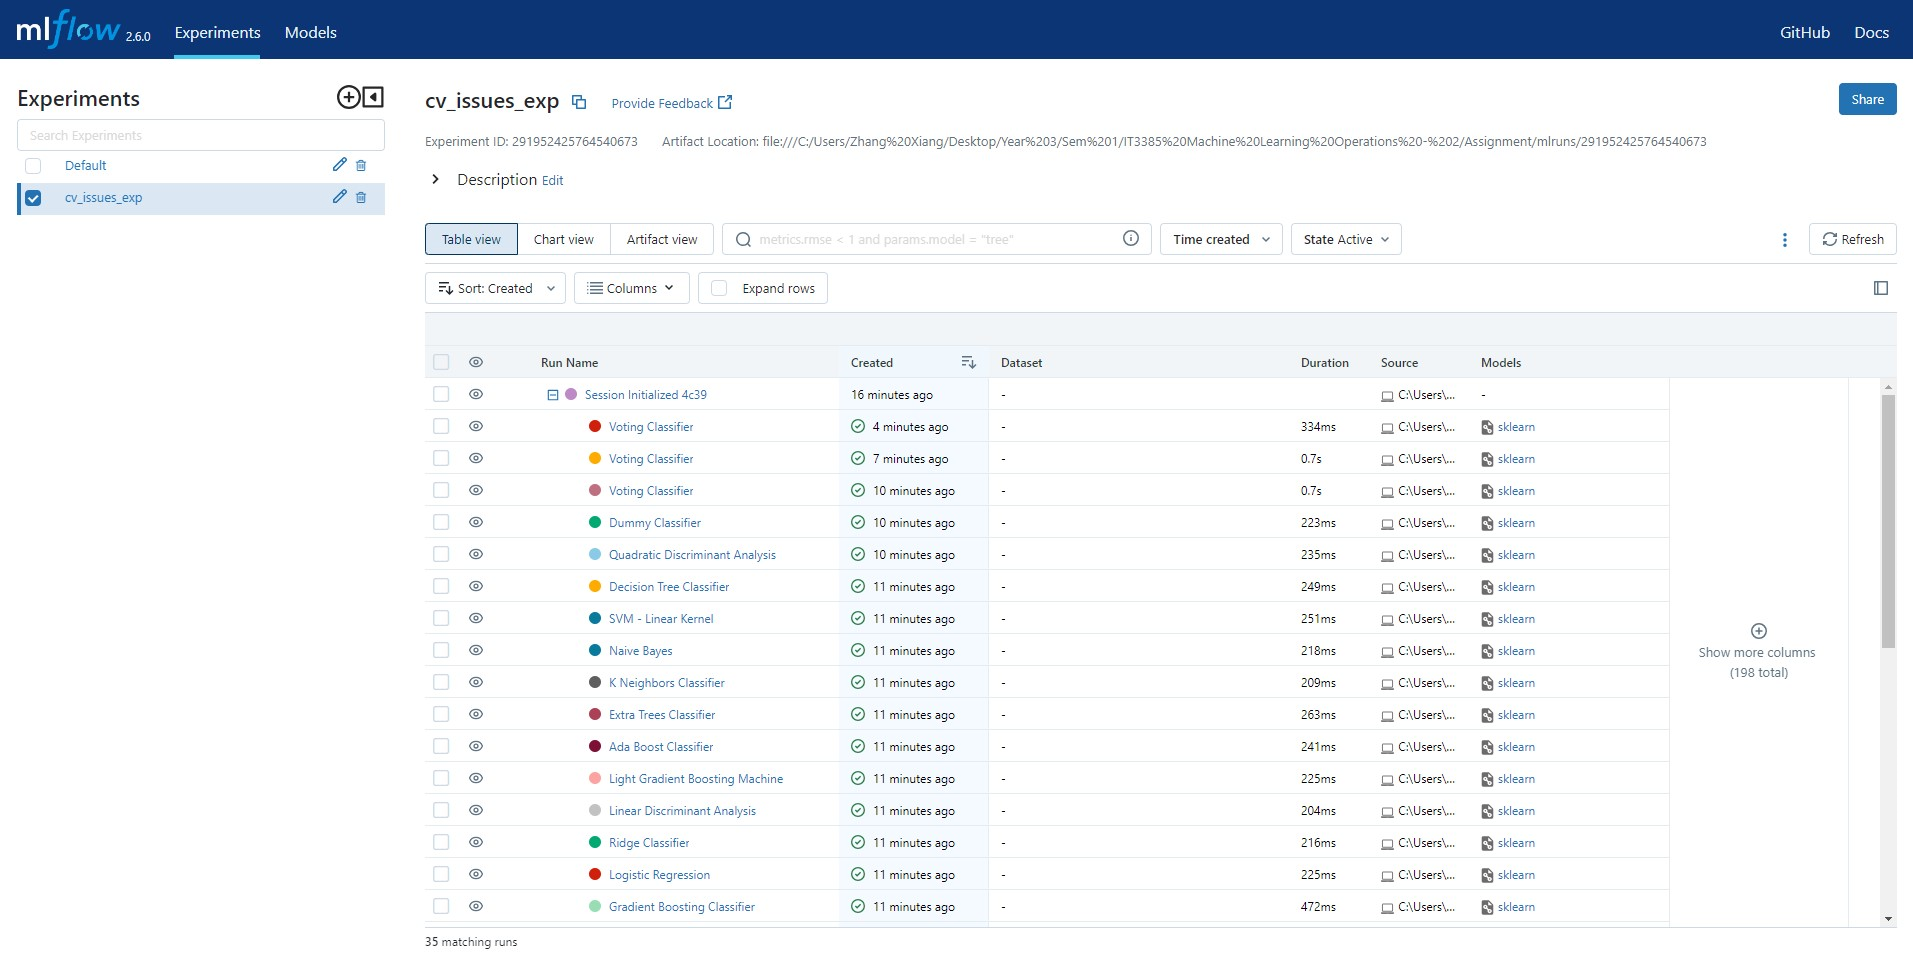

With that I will select the best model for MLFlow Registration.

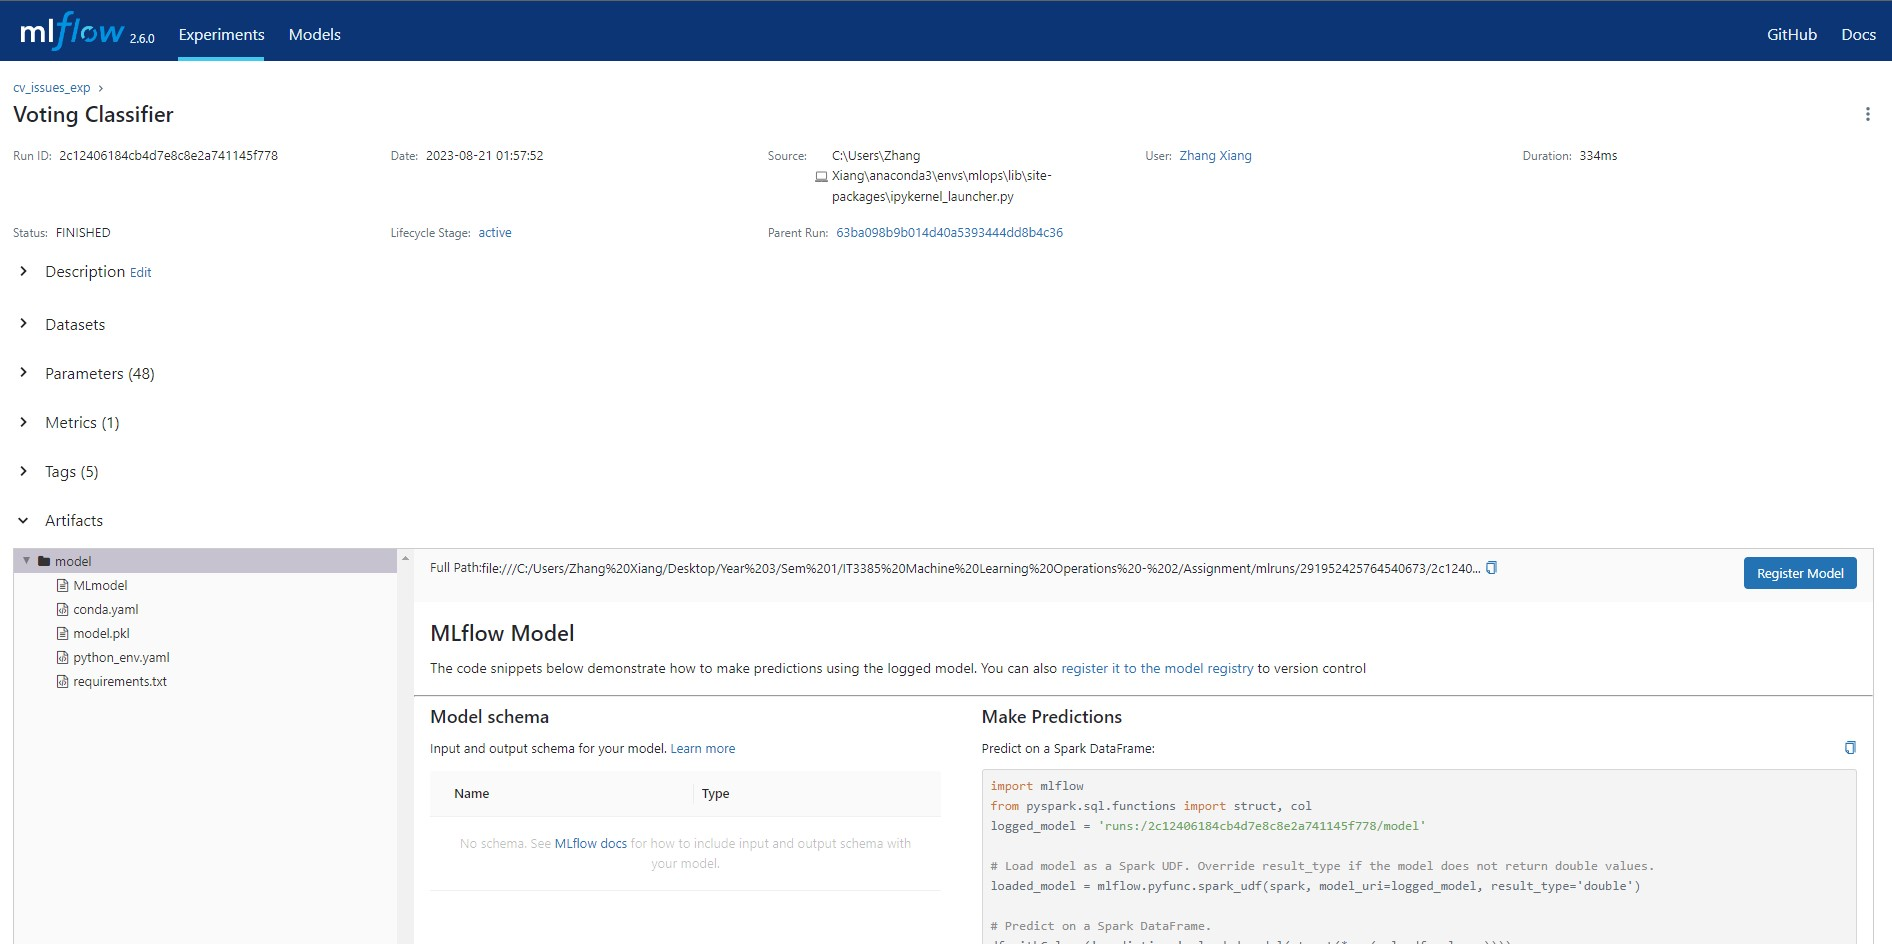

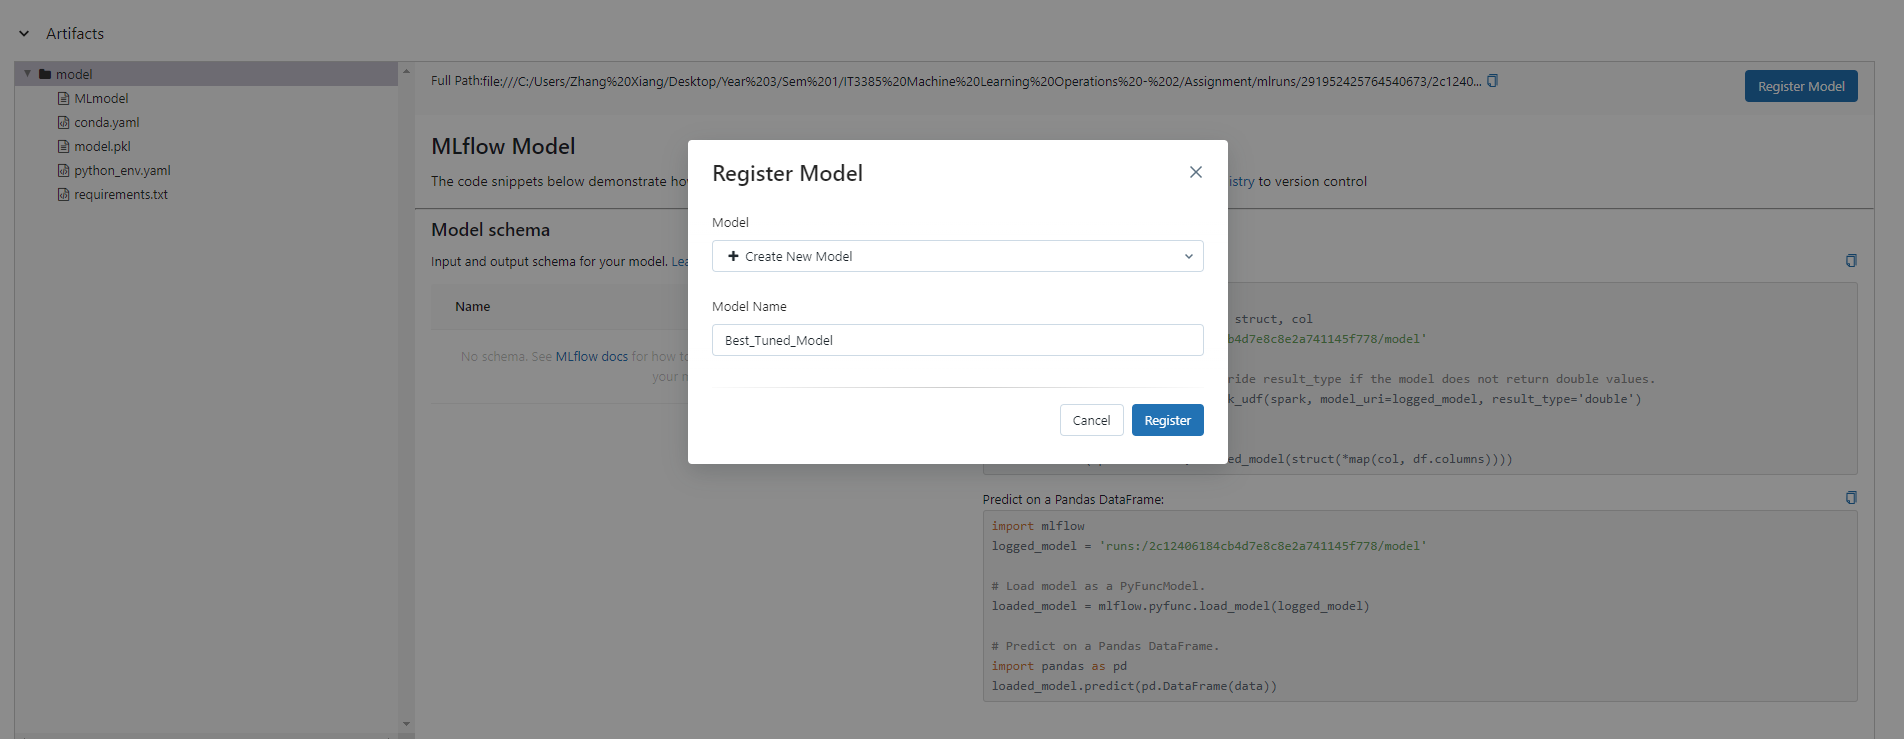

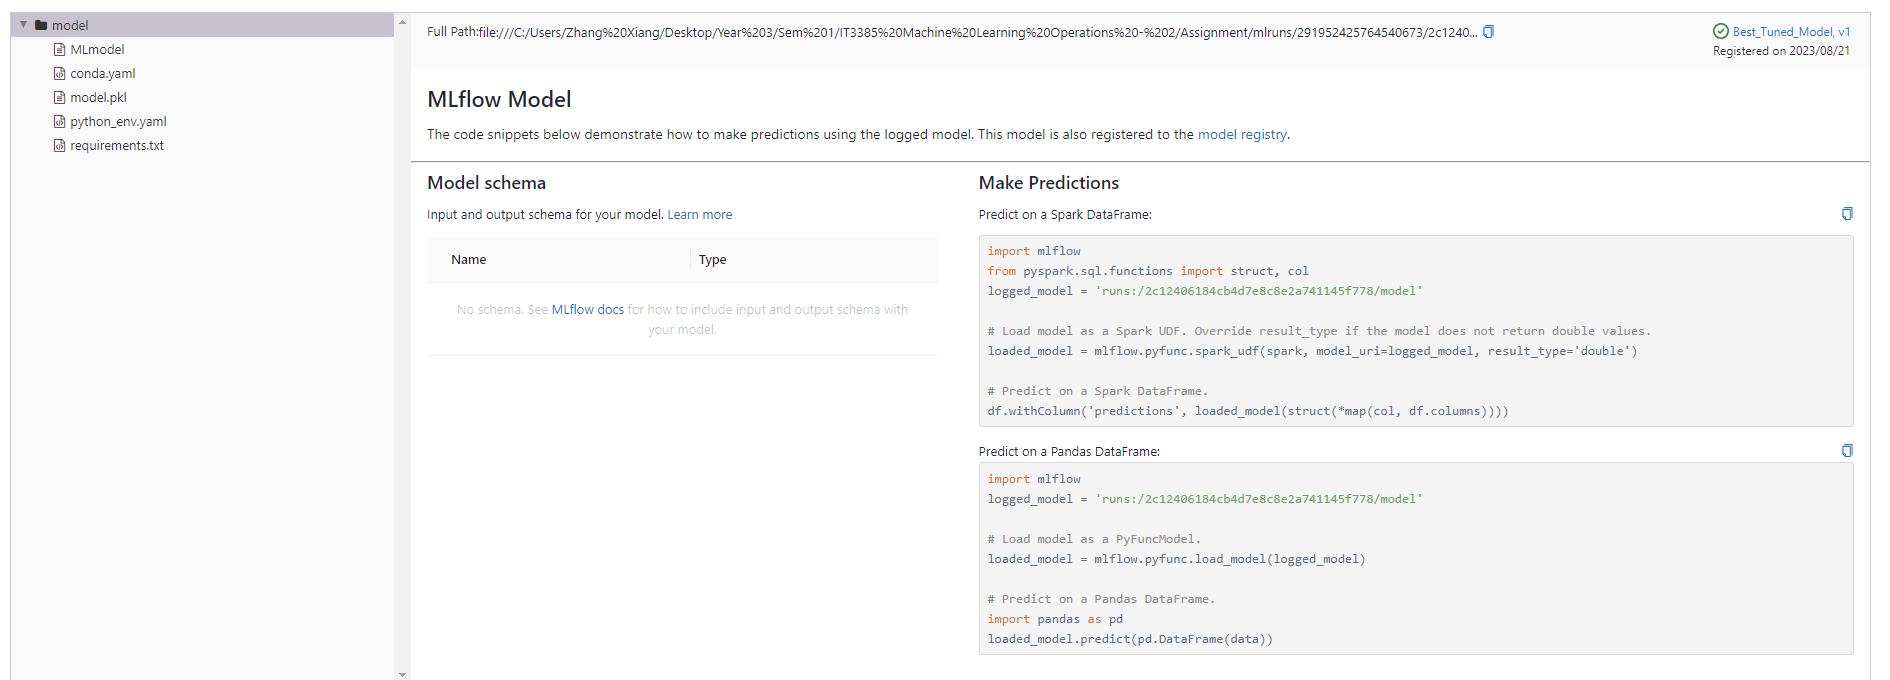

Prove of registered model

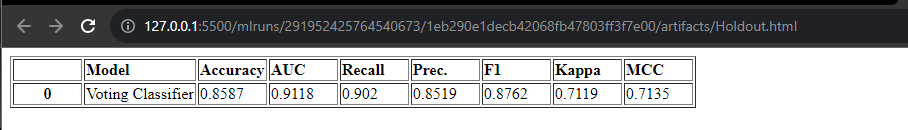

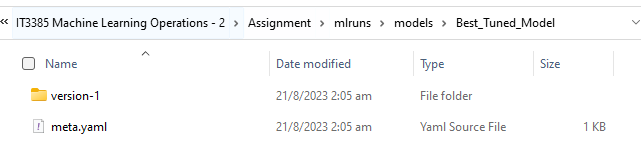

Additional Command Prompt Command:

mlflow ui

mlflow server --backend-store-uri sqlite:///:memory --default-artifact-root ./mlruns

In [63]:
print(mlflow.get_artifact_uri())

file:///C:/Users/Zhang%20Xiang/Desktop/Year%203/Sem%201/IT3385%20Machine%20Learning%20Operations%20-%202/Assignment/mlruns/291952425764540673/63ba098b9b014d40a5393444dd8b4c36/artifacts


In [ ]:
# !mlflow ui

In [ ]:
# with mlflow.start_run():
#     print(mlflow.get_artifact_uri())

In [ ]:
# import mlflow
# logged_model = 'runs:/2c12406184cb4d7e8c8e2a741145f778/model'

# # Load model as a PyFuncModel.
# loaded_model = mlflow.pyfunc.load_model(logged_model)

# # Predict on a Pandas DataFrame.
# import pandas as pd
# loaded_model.predict(pd.DataFrame(data))